Connected to ldm (Python 3.8.5)

/home/shendi_gjh_cj/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


save folder: /home/shendi_gjh_cj/codes/3D_project/logs/E11-4
vmin=-0.446260005235672
vmax=1.0


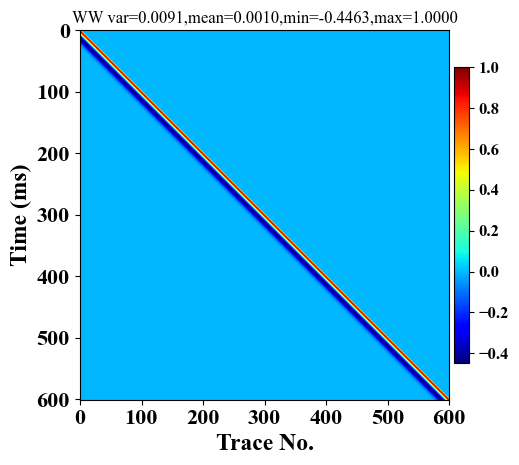

/home/shendi_gjh_cj/anaconda3/envs/ldm/lib/python3.8/site-packages/pylops/utils/signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


vmin=-0.446260005235672
vmax=1.0


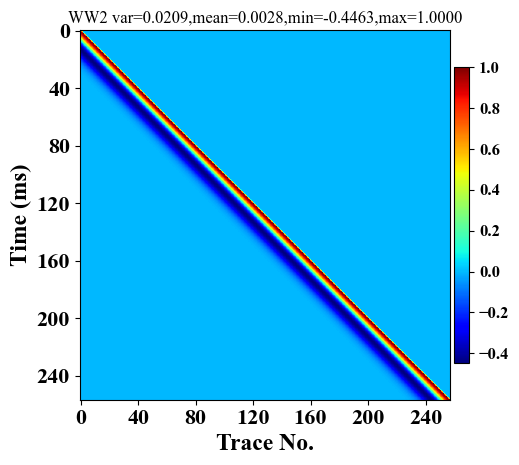

In [ ]:
# cython:language_level=39
# -*- coding: utf-8 -*-
import os
import traceback
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Specify which GPU to use
"""
Created on Wed Apr 10 10:55:26 2024
2D 反演 unet
@author: ET
"""
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/shendi_gjh_cj/codes/3D_project")
sys.path.append("/home/shendi_gjh_cj/codes/3D_project/codes")
import torch
import numpy as np
#import matplotlib.pyplot as plt
# import pylops
from scipy.signal.windows import tukey
from scipy import signal
import pdb
from tqdm import tqdm
# from et_socket import *
from wi_inv_model import UNet, DIPLoss
from Model.net2D import forward_model
import os
from utils import tv_loss


import data_tools as tools

sup_coeff=15
unsup_coeff=5
dip_coeff=20
save_folder="/home/shendi_gjh_cj/codes/3D_project/logs/E11-4"

print("save folder:",save_folder)

def custom_convmtx(h, n_samples, center):
    """
    替代pylops.utils.signalprocessing.convmtx

    参数:
        h (np.ndarray): 输入卷积核（一维数组）
        n_samples (int): 输出信号的样本数（矩阵的列数）
        center (int): 卷积核的中心位置（索引）

    返回:
        np.ndarray: 卷积矩阵（形状为 (n_samples, n_samples)）
    """
    h = np.asarray(h) / np.max(h)  # 归一化卷积核
    h_len = len(h)
    # 计算总行数（卷积后的理论长度）
    total_rows = h_len + n_samples - 1
    # 初始化全零矩阵
    matrix = np.zeros((n_samples, total_rows))

    # 填充托普利茨结构
    for i in range(total_rows):
        start_col = i - center  # 当前行的起始列位置
        for j in range(h_len):
            col_idx = start_col + j
            if 0 <= col_idx < n_samples:
                matrix[col_idx, i] = h[j]

    # 返回前 n_samples 行
    return matrix[:, :n_samples]

from utils import wavelet_init
wav = wavelet_init(601).squeeze().numpy()
WW = custom_convmtx(wav, 601, 0)
WW = WW.astype(np.float32)
tools.single_imshow(WW[:,:],title="WW")

import pylops
nt0=601
# WW2= pylops.utils.signalprocessing.convmtx(wav, nt0, len(wav)//2)[:601]
WW2 = pylops.utils.signalprocessing.convmtx(wav, 257, 0)[:257]
tools.single_imshow(WW2[:,:],title="WW2")


def custom_convmtx2(h, n_samples, center):
    """
    替代pylops.utils.signalprocessing.convmtx

    参数:
        h (np.ndarray): 输入卷积核（一维数组）
        n_samples (int): 输出信号的样本数（矩阵的列数）
        center (int): 卷积核的中心位置（索引）

    返回:
        np.ndarray: 卷积矩阵（形状为 (n_samples, n_samples)）
    """
    h_len = len(h)
    # 计算总行数（卷积后的理论长度）
    total_rows = h_len + n_samples - 1
    # 初始化全零矩阵
    matrix = np.zeros((n_samples, total_rows))

    # 填充托普利茨结构
    for i in range(total_rows):
        start_col = i - center  # 当前行的起始列位置
        for j in range(h_len):
            col_idx = start_col + j
            if 0 <= col_idx < n_samples:
                matrix[col_idx, i] = h[j]

    # 返回前 n_samples 行
    return matrix[:, :n_samples]

class WIInv:
    def __init__(self):
        self._device = None             #设备
        self._model = None              #阻抗网络
        self._modelF = None             #子波网络
        
        self._lossfun = None            #有监督损失函数
        self._lossfunF = None           #无监督损失函数
        self._diploss = None            #diploss损失函数
        self._optimizer = None          #阻抗网络优化器
        self._optimizerF = None         #子波网络优化器
        self._scheduler = None          #阻抗网络学习率迭代器

        self._epsI = 0.1

        self._fLoss = 10.0              #最优损失
        self._fLearningRate = 0.005    #学习率
        self._nCmp = 0                  #最大剖面道数
        self._nSample = 0               #剖面采样数
        self._fSampleStep = 0           #采样率s
        self._sSavePath = ""            #模型保存路径
        self._nTrainWavelet = 0         #子波网络训练次数
        self._nTrainImp = 0             #阻抗网络训练epoch
        self._nTrainBanch = 0           #batchsize

        self._wav = None                #初始子波
        self._nWav = 0                  #子波长
        self._gaussian_window = None    #子波边缘矫正窗函数
        self._LP_A = None               #初始阻抗低通滤波系数分母
        self._LP_B = None               #初始阻抗低通滤波系数分子
        self._avg_seis = 0              #地震归一化参数均值
        self._stddev_seis = 0           #地震归一化参数值域跨度
        self._avg_imp = 0               #log初始阻抗归一化参数均值
        self._stddev_imp = 0            #log初始阻抗归一化参数值域跨度

        self.vSeis = None               #训练地震剖面缓存
        self.vImp = None                #训练初始阻抗剖面缓存
        self.vImpLow = None             #训练初始阻抗低频剖面缓存
        self.vMask = None               #训练掩码剖面缓存

        self.WW = None                  #方阵化子波缓存
        self.PP = None                  #方阵化子波缓存
        self.mid_x   = 0                #最小二乘归一化参数均值
        self.range_x = 0                #最小二乘归一化参数值域跨度

        self.iloop = 0
         
    #差分
    def DIFFZ(self, z):
        DZ = torch.zeros([z.shape[0], z.shape[1], z.shape[2], z.shape[3]], dtype=torch.float32).to(self._device)
        DZ[...,:-1,:] = 0.5*(z[...,1:, :] - z[..., :-1, :])
        return DZ

    #初始化超参数
    #子波网络训练次数，阻抗网络训练epoch，batchsize，最大剖面道数，剖面采样数，采样率s，模型保存路径，子波数组，地震均值，地震值域跨度，初始阻抗均值，初始阻抗值域跨度
    def reset(self, nTrainWavelet, nTrainImp, nTrainBanch, nCmp, nSample, fSampleStep, sSavePath, vWavelet, avg_seis, 
    stddev_seis, avg_imp, stddev_imp, vSeis_min, vSeis_max, vImp_min, vImp_max,train_loader=None):
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._nTrainWavelet = nTrainWavelet
        self._nTrainImp = nTrainImp
        self._nTrainBanch = nTrainBanch
        self._nCmp = nCmp
        self._nSample = nSample
        self._fSampleStep = fSampleStep
        self._sSavePath = sSavePath
        self._nWav = vWavelet.size
        # self._wav = torch.tensor(vWavelet[None, None, :, None]).to(self._device)

        self._wav = torch.tensor((vWavelet/np.max(vWavelet))[None, None, :, None]).to(self._device)
        self._avg_seis = avg_seis
        self._stddev_seis = stddev_seis
        self._avg_imp = avg_imp
        self._stddev_imp = stddev_imp

        self._vSeis_min = vSeis_min
        self._vSeis_max = vSeis_max
        self._vImp_min = vImp_min
        self._vImp_max = vImp_max
        self.train_loader = train_loader

        #self._gaussian_window = gaussian(self._nWav, std = 1.0 / self._fSampleStep / 60)
        self._gaussian_window = tukey(self._nWav, 0.5)
        self._LP_B, self._LP_A = signal.butter(2, 12 * self._fSampleStep, 'low')

        print(self._nTrainWavelet,self._nTrainImp,self._nTrainBanch,self._nCmp,self._nSample,self._nWav,self._fSampleStep)

    #初始化网络
    #sOpenModel预测时加载最优模型路径
    def open(self, sOpenModel):
        self._model      = UNet(2, 1, channels=(8, 16, 32, 64), skip_channels=(0, 8, 16, 32), use_sigmoid=True, use_norm=False).to(self._device)
        #self._model      = CG_net(2,8).to(self._device)
        self._modelF     = forward_model(nonlinearity="tanh").to(self._device)
        self._lossfun    = torch.nn.MSELoss()
        #self._lossfun    = MAELoss()
        self._lossfunF   = torch.nn.MSELoss()
        self._optimizer  = torch.optim.Adam(self._model.parameters(), lr=self._fLearningRate)  # using ADAM opt
        self._optimizerF = torch.optim.Adam(self._modelF.parameters(), lr=self._fLearningRate)
        self._scheduler  = torch.optim.lr_scheduler.StepLR(self._optimizer, gamma=.98, step_size=self._nTrainImp)
        self._diploss    = DIPLoss(self._device, int(0.02 / self._fSampleStep))

        if sOpenModel != "":
            try:
                self._model.load_state_dict(torch.load(sOpenModel)) 
                self._modelF.load_state_dict(torch.load(sOpenModel+"F")) 
                self._model.eval()
                self._modelF.eval()
                # print(QtCore.QCoreApplication.translate("etpyWIInv", "加载最优模型"))
            except:
                traceback.print_exc()
                # print(QtCore.QCoreApplication.translate("etpyWIInv", "加载最优模型失败"))
                return 0

        return 1

    #预处理训练数据缓存
    #vSeis地震剖面，vImp原始阻抗，vMask一维掩码
    def setTrainData(self, vSeis, vImp, vMask):
        # vSeis = [torch.tensor(arr, dtype=torch.float32) for arr in vSeis]
        # vImp = [torch.tensor(arr, dtype=torch.float32) for arr in vImp]
        # vMask = [torch.tensor(arr, dtype=torch.float32) for arr in vMask]
        self.vSeis = []
        self.vImp = []
        self.vImpLow = []
        self.vMask = []

        # pdb.set_trace()

        for i in range(len(vSeis)):
            seis = vSeis[i]
            nanSeie = np.where(np.isnan(seis))
            imp  = np.where(np.isnan(vImp[i]), np.float32(1.0), vImp[i])
            imp  = np.where(imp < 1, np.float32(1.0), imp)
            # imp  = np.log(imp)  #阻抗对数化
            # nanImp = np.where(imp==0)


            # #合并地震和阻抗无效区域
            # union_indices = set(zip(*nanSeie)) | set(zip(*nanImp))
            # union_rows, union_cols = zip(*union_indices)
            # nanPred = (np.array(union_rows), np.array(union_cols))

            # seis[nanPred] = 0
            # seis = (seis - self._avg_seis) / self._stddev_seis
            seis = 2*(seis - self._vSeis_min) / (self._vSeis_max-self._vSeis_min) - 1
            self.vSeis.append(np.clip(seis, -5.0, 5.0))
            # imp[nanPred] = imp[np.where(imp!=0)].min()




            impLow = signal.filtfilt(self._LP_B, self._LP_A, imp.T) #滤低频阻抗
            impLow = signal.filtfilt(np.ones(3)/float(3), 1, impLow)
            impLow = signal.filtfilt(np.ones(3)/float(3), 1, impLow.T).astype(np.float32)
            # pdb.set_trace()
            imp = (imp-self._vImp_min) / (self._vImp_max-self._vImp_min)
            impLow = (impLow-self._vImp_min) / (self._vImp_max-self._vImp_min)
            # imp = (imp - self._avg_imp) / self._stddev_imp
            # impLow = (impLow - self._avg_imp) / self._stddev_imp
            mask = np.tile(vMask[i], [seis.shape[0], 1])  #掩码复制成二维
            # mask[nanPred] = 0

            self.vImp.append(imp)
            self.vImpLow.append(impLow)
            self.vMask.append(mask)

            #if i%10==0:
            #    plt.imsave("d:/test/vSeis/vSeisIN_%d.png"%(self.iloop), self.vSeis[-1], cmap='gray')
            #    plt.imsave("d:/test/vLabel/vImpIN_%d.png"%(self.iloop), self.vImp[-1], cmap='gray')
            #    self.iloop += 1

    #取一个训练数据
    def GetExample(self):
        vSeis = []
        vImp = []
        vImpLow = []
        vMask = []

        for _ in range(self._nTrainBanch):
            # pdb.set_trace()
            example_select = np.random.randint(0, len(self.vSeis))
            if self.vSeis[example_select].shape[1] > self._nCmp:    #超过最大剖面道数裁剪输入
                while 1:    #训练数据必需包含井
                    startcmp = np.random.randint(0, self.vSeis[example_select].shape[1] - self._nCmp)
                    if np.sum(self.vMask[example_select][None, :, startcmp:startcmp+self._nCmp]) > 0:
                        break
                vSeis.append(self.vSeis[example_select][None, :, startcmp:startcmp+self._nCmp])
                vImp.append(self.vImp[example_select][None, :, startcmp:startcmp+self._nCmp])
                vImpLow.append(self.vImpLow[example_select][None, :, startcmp:startcmp+self._nCmp])
                vMask.append(self.vMask[example_select][None, :, startcmp:startcmp+self._nCmp])
            else:
                vSeis.append(self.vSeis[example_select][None])
                vImp.append(self.vImp[example_select][None])
                vImpLow.append(self.vImpLow[example_select][None])
                vMask.append(self.vMask[example_select][None])


        max_length = max(arr.shape[2] for arr in vSeis)
        min_length = min(arr.shape[2] for arr in vSeis)
        if max_length != min_length:    #batch间数据道数不一致填充成一样
            for i in range(self._nTrainBanch):
                if max_length != vSeis[i].shape[2]:
                    vSeis[i] = np.pad(vSeis[i], ((0,0), (0,0), (0,max_length-vSeis[i].shape[2])), 'edge')
                    vImp[i] = np.pad(vImp[i], ((0,0), (0,0), (0,max_length-vImp[i].shape[2])), 'edge')
                    vImpLow[i] = np.pad(vImpLow[i], ((0,0), (0,0), (0,max_length-vImpLow[i].shape[2])), 'edge')
                    vMask[i] = np.pad(vMask[i], ((0,0), (0,0), (0,max_length-vMask[i].shape[2])), 'edge')

        vSeis = torch.tensor(np.asarray(vSeis)).to(self._device)
        vImp = torch.tensor(np.asarray(vImp)).to(self._device)
        vImpLow = torch.tensor(np.asarray(vImpLow)).to(self._device)
        vMask = torch.tensor(np.asarray(vMask)).to(self._device)
        vSeis = vSeis.float()
        vImp = vImp.float()
        vImpLow = vImpLow.float()
        vMask = vMask.float()
        return vSeis, vImp, vImpLow, vMask

    #训练子波网络，初始化子波相关参数
    def trainWavelet(self):
        lossw = 0
        lossF_list=[]
        # progressBar.progress(progressBar.START, self._nTrainWavelet, QtCore.QCoreApplication.translate("etpyWIInv", "训练子波"))
        # for iter in tqdm(range(self._nTrainWavelet),desc="Training Wavelet"):
        for iter in range(self._nTrainWavelet):
            for vSeis, vImp, _, vMask in self.train_loader:
                vSeis = vSeis.to(self._device)
                vImp = vImp.to(self._device)
                vMask = vMask.to(self._device)
                # vSeis, vImp, _, vMask = self.GetExample()
                # pdb.set_trace()
                self._optimizerF.zero_grad()
                # vImp=vImp.float()
                self._wav=self._wav.float()

                # pdb.set_trace()
                predF = self._modelF(self.DIFFZ(vImp), self._wav)
                # pdb.set_trace()
             
                # plt.plot(vSeis[0,0,:,10].cpu().detach().numpy(),label="vSeis")
                # plt.plot(predF[0][0,0,:,10].cpu().detach().numpy(),label="predF")
                # plt.legend()
                # plt.show()
                lossF = self._lossfunF(vMask * predF[0], vMask * vSeis)
                # pdb.set_trace()
                # loss
                # _nSample=601
                # vSeis.shape[3]=120
                # self._nTrainBanch 就是batchsize
                lossF= lossF*vSeis.shape[0]*vSeis.shape[3]*vSeis.shape[2]/torch.sum(vMask)
                # lossF*=self._nTrainBanch*self._nSample*vSeis.shape[3]/torch.sum(vMask)
                lossF.backward()
                self._optimizerF.step()
                lossw += lossF.item()
                lossF_list.append(lossF.item())
                # progressBar.progress(progressBar.STEP)
                # tqdm.set_postfix_str(f"Loss: {lossF.item():.4f}")
                print(f"Epoch: {iter:2d}, Loss: {lossF:.4f}", end='\r', flush=True)
                # print(f"Epoch: {iter:2d}, Loss: {lossF:.4f}")
        print('train wavelet ->final_loss:',lossF)


        plt.plot(lossF_list)
        plt.title("第一阶段损失函数")
        plt.show()
        # re_sesimic,_ = self._modelF(self.DIFFZ(tensor_true_3d), self._wav)
        # well_true=re_sesimic[0,0,:,140].cpu().detach().numpy()
        # plt.plot(well_true,label="re_sesimic")
        # plt.plot(seismic_3d[:,140,0],label="true_sesimic")
        # plt.legend()
        # plt.show()

        lossw /= self._nTrainWavelet
        print('total loss:',lossw)

        #print("LastWaveletLoss:",self._nTrainBanch*self._nSample*vSeis.shape[3]/torch.sum(vMask),lossF.item())
        # print(QtCore.QCoreApplication.translate("etpyWIInv", "子波损失") + ":",lossw)
        # progressBar.progress(progressBar.STOP)

        try:
            torch.save(self._modelF.state_dict(),self._sSavePath+"F")
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "保存子波模型"))
        except:
            traceback.print_exc()
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "保存子波模型失败"))
            return 0

        self._modelF.eval()
        pdb.set_trace()
        # _, vImp, _, _ = self.GetExample()
        sei, wav0  = self._modelF(self.DIFFZ(vImp), self._wav)
        tools.single_imshow(vSeis[2,0].cpu().detach().numpy())
        tools.single_imshow(sei[2,0].cpu().detach().numpy())
        tools.single_imshow(vMask[2,0].cpu().detach().numpy())

        print("vseis_max:",vSeis[2,0].max(),"vseis_min:",vSeis[2,0].min(),"vseis_mean:",vSeis[2,0].mean())

        plt.plot(vSeis[2,0,:,4].cpu().detach().numpy(),label="vSeis")
        plt.plot(sei[2,0,:,4].cpu().detach().numpy(),label="re_sei")
        plt.legend()
        plt.show()

        wav0=wav0.detach().cpu().squeeze().numpy()
        wav00 = self._gaussian_window * (wav0 - wav0.mean())
        S = torch.diag(0.5 * torch.ones(self._nSample - 1), diagonal=1) - torch.diag(0.5 * torch.ones(self._nSample - 1), diagonal=-1)
        S[0] = S[-1] = 0
        # WW = pylops.utils.signalprocessing.convmtx(wav00/wav00.max(), self._nSample, self._nWav // 2)[:self._nSample]
        WW = custom_convmtx(wav00, self._nSample, self._nWav // 2)
        WW = torch.tensor(WW.astype(np.float32)).to(self._device)
        self.WW = WW @ S.to(self._device)
        self.PP = (torch.matmul(self.WW.T, self.WW) + self._epsI * (torch.eye(self.WW.shape[0])).to(self._device))[None,None]

        pdb.set_trace()

        ## 把WW和PP保存为npz
        np.savez(os.path.join(save_folder,"WW_PP.npz"),WW=self.WW.cpu().detach().numpy(),PP=self.PP.cpu().detach().numpy())

        #统计最小二乘归一化参数
        # for _ in range(10):
        #     vSeis, _, vImpLow, _ = self.GetExample()
        #     datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow))
        #     x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
        #     x = x + vImpLow
        #     self.mid_x += (x.max() + x.min()) / 2
        #     self.range_x += (x.max() - x.min()) / 2
        # self.mid_x /= 10
        # self.range_x /= 10
        


        return lossw

    #训练阻抗网络
    def train(self):
        self._model.train()
        loss = 0
        #losss=0
        #lossd=0
        #lossu=0
        vmin=float('inf')
        vmax=float('-inf')

        for vSeis, vImp, vImpLow, vMask in self.train_loader:
            vSeis = vSeis.to(self._device)
            vImp = vImp.to(self._device)
            vImpLow = vImpLow.to(self._device)
            datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow)) #减去低频背景的影响，借鉴的pylops
            x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
            x = x + vImpLow
            batch_vmin = x.min().item()
            batch_vmax = x.max().item()
            vmin = min(vmin, batch_vmin)
            vmax = max(vmax, batch_vmax)
        print(f"训练时,vmin: {vmin}, vmax: {vmax}")

        print(f"sup_coeff: {sup_coeff}, unsup_coeff: {unsup_coeff}, dip_coeff: {dip_coeff}")
        for i in range(self._nTrainImp):
            for vSeis, vImp, vImpLow, vMask in self.train_loader:
                vSeis = vSeis.to(self._device)
                vImp = vImp.to(self._device)
                vImpLow = vImpLow.to(self._device)
                vMask = vMask.to(self._device)
                # vSeis, vImp, vImpLow, vMask = self.GetExample()
                # pdb.set_trace()
                self._optimizer.zero_grad()
                datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow)) #减去低频背景的影响，借鉴的pylops
                x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
                x = x + vImpLow  #最小二乘解
                # x_n = (x-vmin) / (vmax - vmin)
                x_n= (x-x.min())/(x.max()-x.min())
                # x_n = (x - self.mid_x) / self.range_x #(x-x.min())/(x.max()-x.min())  #进行了一步归一化，避免最小二乘大小带来的影响

                pred = self._model(torch.cat([x_n, vSeis], dim=1)) + x_n
                predF = self._modelF(self.DIFFZ(pred), self._wav)
                loss_sup   = self._lossfun(vMask * pred, vMask * vImp) * self._nTrainBanch*self._nSample*vSeis.shape[3]/torch.sum(vMask)
                loss_unsup = self._lossfunF(predF[0], vSeis)
                loss_tv   = tv_loss(pred,1.0)
                loss_dip,_ = self._diploss(vSeis, pred)
   
                total_loss = sup_coeff*loss_sup + unsup_coeff*loss_unsup + dip_coeff*loss_dip
                loss += total_loss.item()
                #losss += loss_sup.item()
                #lossd += loss_tv.item()
                #lossu += loss_unsup.item()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self._model.parameters(), max_norm=1)  
                self._optimizer.step()  
                self._scheduler.step()
                print(f"Epoch: {i:2d}, Loss: {total_loss:.4f}", end='\r', flush=True)
            print("end training!")

            #if i%50==0:
            #    for ib in range(len(vSeis)):
            #        plt.imsave("d:/test/vSeis/vSeis_%d.png"%(self.iloop), vSeis[ib,0].cpu().detach().numpy(), cmap='gray')
            #        plt.imsave("d:/test/vLabel/vImp_%d.png"%(self.iloop), vImp[ib,0].cpu().detach().numpy(), cmap='gray')
            #        #vImpLow.cpu().detach().numpy().tofile("d:/test/vLabel/vImpLow_%d.bin"%(self.iloop))
            #        #x.cpu().detach().numpy().tofile("d:/test/vMask/vMask_%d.bin"%(self.iloop))
            #        plt.imsave("d:/test/vRet/vPred_%d.png"%(self.iloop), pred[ib,0].cpu().detach().numpy(), cmap='gray')
            #        #predF[0].cpu().detach().numpy().tofile("d:/test/vRet/vPredF_%d.bin"%(self.iloop))
            #        self.iloop += 1
        print("loss:",loss)
        loss /= self._nTrainImp
        #losss /= self._nTrainImp
        #lossd /= self._nTrainImp
        #lossu /= self._nTrainImp
        #print("sup:",losss)
        #print("unsup:",lossu)
        #print("dip:",lossd)
        # pdb.set_trace()
        if loss < self._fLoss:
            self._fLoss = loss
            res = self.save()
            if res == 0:
                return -1;
        else:
            self._fLoss = self._fLoss * 1.005
        self.iloop += 1
        return loss

    #保存模型
    def save(self):
        if self._sSavePath == "":
            return 1
        try:
            # pdb.set_trace()
            torch.save(self._model.state_dict(), self._sSavePath)
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "成功保存模型于") + ':',self.iloop)
        except:
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "保存模型错误"))
            return 0
        return 1

    #预测一个剖面
    def pred(self, vSeis=None, vImp=None):
        # nanSeie = np.where(np.isnan(vSeis))
        # vImp = np.where(np.isnan(vImp), np.float32(1.0), vImp)
        # vImp = np.where(vImp < 1, np.float32(1.0), vImp)
        # # vImp = np.log(vImp)
        # # nanImp = np.where(vImp==0)
        # # union_indices = set(zip(*nanSeie)) | set(zip(*nanImp))
        # # union_rows, union_cols = zip(*union_indices)
        # # nanPred = (np.array(union_rows), np.array(union_cols))


        # # vSeis[nanPred] = 0
        # # vSeis = (vSeis - self._avg_seis) / self._stddev_seis
        # vSeis = 2*(vSeis - self._vSeis_min) / (self._vSeis_max-self._vSeis_min) - 1
        # vSeis = np.clip(vSeis, -5.0, 5.0)
        
        # # vImp[nanPred] = vImp[np.where(vImp!=0)].min()

        # vImpLow = signal.filtfilt(self._LP_B, self._LP_A, vImp.T)
        # vImpLow = signal.filtfilt(np.ones(3)/float(3), 1, vImpLow)
        # vImpLow = signal.filtfilt(np.ones(3)/float(3), 1, vImpLow.T).astype(np.float32)

        # vImpLow = (vImpLow - self._vImp_min) / (self._vImp_max-self._vImp_min) 
        # # vImpLow = (vImpLow - self._avg_imp) / self._stddev_imp
        # vSeis = torch.tensor(vSeis[None,None]).float().to(self._device)
        # vImpLow = torch.tensor(vImpLow[None,None]).float().to(self._device)
        ##读取self.WW和self.PP
        WW=np.load(os.path.join(save_folder,"WW_PP.npz"))["WW"]
        PP=np.load(os.path.join(save_folder,"WW_PP.npz"))["PP"]
        self.WW=torch.tensor(WW).to(self._device)
        self.PP=torch.tensor(PP).to(self._device)

        vmin=float('inf')
        vmax=float('-inf')
        with torch.no_grad():
            for i, (vSeis, vImpLow, _, _) in enumerate(self.test_loader):
                vSeis = vSeis.to(self._device)
                vImpLow = vImpLow.to(self._device)
                datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow))
                x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
                x = x + vImpLow
                batch_vmin = x.min().item()
                batch_vmax = x.max().item()
                vmin = min(vmin, batch_vmin)
                vmax = max(vmax, batch_vmax)
        
        print(f"推理时,vmin: {vmin}, vmax: {vmax}")


        pred_patch_list = []
        true_patch_list = []
        seismic_patch_list = []
        indices_list = []
        implow_patch_list = []

        with torch.no_grad():
            for i, (vSeis, vImp,vImpLow, indice) in enumerate(self.test_loader):
                if i>150:break
                vSeis = vSeis.to(self._device)
                vImpLow = vImpLow.to(self._device)
                # vImp = vImp.to(self._device)
                # pdb.set_trace()
                datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow))
                x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
                x = x + vImpLow
                x_n = (x-vmin) / (vmax - vmin)
                # x_n = (x - x.min()) / (x.max() - x.min())
                # x_n = (x - self.mid_x) / self.range_x #(x-x.min())/(x.max()-x.min()) 
          
                vPred = self._model(torch.cat([x_n, vSeis], dim=1)) + x_n
                assert torch.isnan(vPred).any() == False
             
                # pdb.set_trace()
                pred_patch_list.extend(list(np.squeeze(vPred.cpu().numpy(), axis=1)))
                true_patch_list.extend(list(np.squeeze(vImp.cpu().numpy(), axis=1)))
                seismic_patch_list.extend(list(np.squeeze(vSeis.cpu().numpy(), axis=1)))
                implow_patch_list.extend(list(np.squeeze(vImpLow.cpu().numpy(), axis=1)))
                # pred_patch_list.extend(list(vPred.cpu().detach().squeeze().numpy()))
                indices_list.extend(indice.tolist())
                # break


    
        pred_3d = self.processor.reconstruct_3d_from_patches(pred_patch_list, indices_list)
        true_3d = self.processor.reconstruct_3d_from_patches(true_patch_list, indices_list)
        seismic_3d = self.processor.reconstruct_3d_from_patches(seismic_patch_list, indices_list)
        implow_3d = self.processor.reconstruct_3d_from_patches(implow_patch_list, indices_list)
        ##如果folder不存在，就创建
        
        pred_3d=(pred_3d)*(vmax-vmin)+vmin
        tensor_true_3d=torch.tensor(true_3d[:,:,0].reshape(1,1,601,1189))
        re_sesimic,_ = self._modelF(self.DIFFZ(tensor_true_3d), self._wav)
        well_true=re_sesimic[0,0,:,140].cpu().detach().numpy()
        plt.plot(well_true,label="re_sesimic")
        plt.plot(seismic_3d[:,140,0],label="true_sesimic")
        plt.legend()
        plt.show()
        # plt.close()
        # loss_sup   = self._lossfun(predF[0], seismic_3d) 



        # if not os.path.exists(save_folder):
        #     os.makedirs(save_folder)
        # np.save(os.path.join(save_folder, 'prediction_impedance.npy'), pred_3d)
        # np.save(os.path.join(save_folder, 'true_impedance.npy'), true_3d)
        # np.save(os.path.join(save_folder, 'implow_impedance.npy'), implow_3d)
        # np.save(os.path.join(save_folder, 'seismic_record.npy'), seismic_3d)
        # print("save to ",save_folder)
        # pdb.set_trace()

      
        #vSeis.cpu().detach().numpy().tofile("d:/test/vSeis/vSeis_%d.bin"%(self.iloop))
        #vImp.tofile("d:/test/vLabel/vImp_%d.bin"%(self.iloop))
        #vImpLow.cpu().detach().numpy().tofile("d:/test/vLabel/vImpLow_%d.bin"%(self.iloop))
        #x.cpu().detach().numpy().tofile("d:/test/vMask/vMask_%d.bin"%(self.iloop))
        #vPred.cpu().detach().numpy().tofile("d:/test/vRet/vPred_%d.bin"%(self.iloop))
        #self.iloop += 1

        # vPred = vPred.cpu().detach().squeeze().numpy()
        # vPred = np.exp(vPred * self._stddev_imp + self._avg_imp)
        # vPred[nanPred] = np.nan

        return vPred

    def getCmp(self):
        return self._nCmp

    def getSample(self):
        return self._nSample

predict = WIInv()


def process_socket(vInputBuf):
    streamInput = QtCore.QDataStream(vInputBuf)
    nFunc = streamInput.readUInt8()
    vBuf = QtCore.QByteArray()
    buffer = QtCore.QBuffer(vBuf)
    buffer.open(QtCore.QIODevice.WriteOnly)
    streamOutput = QtCore.QDataStream()
    streamOutput.setDevice(buffer)

    if nFunc == 1:
        nTrainImp = streamInput.readUInt32()
        nTrainBanch = streamInput.readUInt32()
        nCmp = streamInput.readUInt32()
        nSample = streamInput.readUInt32()
        fSampleStep = streamInput.readFloat()
        sSavePath = streamInput.readQString()
        nWavelet = streamInput.readUInt32()
        vWavelet = DecodeFloatArray(streamInput, nWavelet)
        avg_seis = streamInput.readFloat()
        stddev_seis = streamInput.readFloat()
        avg_imp = streamInput.readFloat()
        stddev_imp = streamInput.readFloat()
        predict.reset(int(3000/nTrainBanch), nTrainImp, nTrainBanch, nCmp, nSample, fSampleStep, sSavePath, vWavelet, avg_seis, stddev_seis, avg_imp, stddev_imp)
        streamOutput.writeUInt8(1)

    elif nFunc == 2:
        nSample = predict.getSample()
        vSeis = []
        vImp = []
        vMask = []
        while(1):
            nCrd = streamInput.readUInt32()
            if nCrd == 0:
                break
            data = DecodeFloatArray(streamInput, (nCrd, nSample))
            vSeis.append(np.transpose(data,(1,0)))
            data = DecodeFloatArray(streamInput, (nCrd, nSample))
            vImp.append(np.transpose(data,(1,0)))
            data = DecodeFloatArray(streamInput, nCrd)
            vMask.append(data)
        predict.setTrainData(vSeis, vImp, vMask)
        streamOutput.writeUInt8(1)

    elif nFunc == 3:
        sPath = streamInput.readQString()
        bRet = predict.open(sPath)
        streamOutput.writeUInt8(bRet)

    elif nFunc == 4:
        loss = predict.train()
        streamOutput.writeFloat(loss)

    elif nFunc == 5:
        lossw = predict.trainWavelet()
        streamOutput.writeFloat(lossw)
        
    elif nFunc == 6:
        nSample = predict.getSample()
        nCrd = streamInput.readUInt32()
        vSeis = DecodeFloatArray(streamInput, (nCrd, nSample))
        vImp = DecodeFloatArray(streamInput, (nCrd, nSample))
        vPred = predict.pred(np.transpose(vSeis,(1,0)), np.transpose(vImp,(1,0)))
        EncodeFloatArray(streamOutput, np.transpose(vPred,(1,0)))

    return vBuf


def run():
    StartSocket(process_socket)


# #这个地方需要根据实际的训练数据进行修改，bgp在训练的时候用的是把yyf_smo_train_Volume_PP_IMP当作模型数据，生成地震数据来对网络进行训练
# if __name__ == '__main__':
#     import sys
#     from data_processor import SeismicDataProcessor
#     processor = SeismicDataProcessor(cache_dir='cache',device='cpu',train_batch_size=60,train_patch_size=120)
    
#     S_obs = processor.load_seismic_data()      
#     shape_3d=S_obs.shape    
#     well_pos, M_well_mask, M_well_mask_dict = processor.generate_well_mask(shape_3d)
#     training_data = processor.build_training_profiles(
#         well_pos, M_well_mask_dict
#     )
 
#     avg_imp=training_data['Z_full_train_set'].mean()
#     stddev_imp=training_data['Z_full_train_set'].std()

#     vImp_min=training_data['Z_full_train_set'].min()
#     vImp_max=training_data['Z_full_train_set'].max()

#     avg_seis=training_data['S_obs_train_set'].mean()
#     stddev_seis=training_data['S_obs_train_set'].std()
#     vSeis_min=training_data['S_obs_train_set'].min()
#     vSeis_max=training_data['S_obs_train_set'].max()
    

#     vSeis = []
#     vImp = []
#     vMask = []
#     print("making dataset")
#     for i in tqdm(range(100),desc="Making dataset"):
#         vSeis.append(training_data['S_obs_train_set'][i,0])
#         vImp.append(training_data['Z_full_train_set'][i,0])
#         vMask.append(training_data['M_mask_train_set'][i,0,0])
#     # pdb.set_trace()
#     train_loader, _, _ = processor.process_train_data()

    
#     nTrainWavelet=50
#     nTrainGroup=2
#     nTrainImp=20
#     nTrainBanch=70
#     nCmp=1000
#     nSample=601
#     fSampleStep=0.001
#     # vWavelet=np.random.random(257
#     from utils import wavelet_init
#     vWavelet = wavelet_init(257).squeeze().numpy()


#     print("dataset made, start training wavelet")
#     predict.reset(nTrainWavelet, nTrainImp, nTrainBanch, nCmp, nSample, fSampleStep, 
#     sSavePath=os.path.join(save_folder, "test.pth"), 
#     vWavelet=vWavelet, 
#     avg_seis=avg_seis, 
#     stddev_seis=stddev_seis, 
#     avg_imp=avg_imp, 
#     stddev_imp=stddev_imp,
#     vSeis_min=vSeis_min,
#     vSeis_max=vSeis_max,
#     vImp_min=vImp_min,
#     vImp_max=vImp_max,
#     train_loader=train_loader
#     )



#     predict.processor = processor


#     predict.setTrainData(vSeis, vImp, vMask)
#     predict.open("")
#     # print("training wavelet")
#     predict.trainWavelet()

#     # for iter in tqdm(range(nTrainGroup),desc="Training"):
#         # print("iter:", iter)
#         # vSeis = []
#         # vImp = []
#         # vMask = []
#         # for _ in range(10):
#         #     cmp=np.random.randint(800,1500)
#         #     pdb.set_trace()
#         #     vSeis.append(np.random.random([nSample,cmp]))
#         #     vImp.append(np.random.random([nSample,cmp])+1) #(500,1077)
#         #     vMask.append(np.random.randint(0,2,cmp)) #(1077,)
#         # predict.setTrainData(vSeis, vImp, vMask)
#     predict.train()
#     predict.open(os.path.join(save_folder, "test.pth"))

#     predict.test_axis=0
#     predict.processor = SeismicDataProcessor(cache_dir='cache', device='cpu',test_axis=predict.test_axis)
#     predict.test_loader, _,_,_ = predict.processor.process_test_data(
#         batch_size=50,
#         patch_size=1400
#     )
#     # # vSeis=np.random.random([nSample,nCmp])
#     # # vImp=np.random.random([nSample,nCmp])
#     # vPred=predict.pred(vSeis[0],vImp[0])
#     vPred=predict.pred()

    
    # pdb.set_trace()

save folder: /home/shendi_gjh_cj/codes/3D_project/logs/E11-4
vmin=-0.446260005235672
vmax=1.0


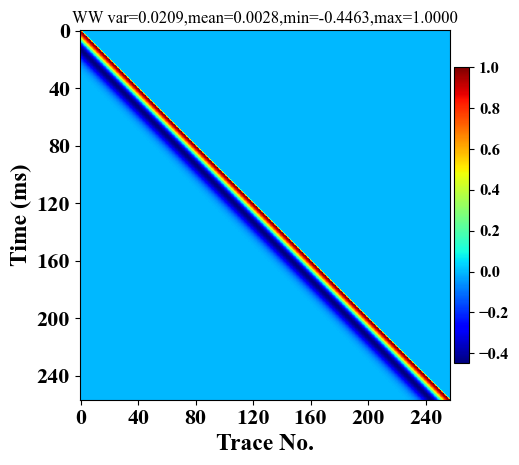

vmin=-0.446260005235672
vmax=1.0


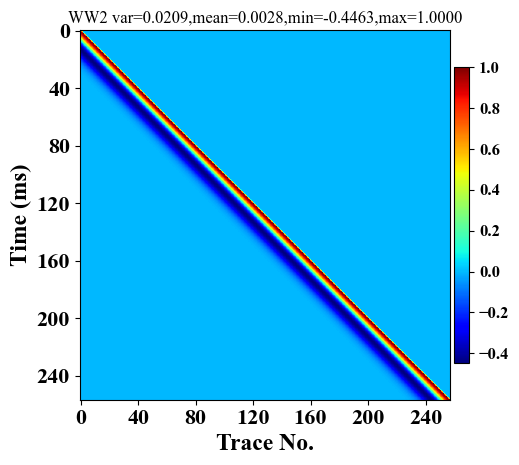

In [ ]:
# cython:language_level=39
# -*- coding: utf-8 -*-
import os
import traceback
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Specify which GPU to use
"""
Created on Wed Apr 10 10:55:26 2024
2D 反演 unet
@author: ET
"""
import matplotlib.pyplot as plt
import sys
sys.path.append("/home/shendi_gjh_cj/codes/3D_project")
sys.path.append("/home/shendi_gjh_cj/codes/3D_project/codes")
import torch
import numpy as np
#import matplotlib.pyplot as plt
# import pylops
from scipy.signal.windows import tukey
from scipy import signal
import pdb
from tqdm import tqdm
# from et_socket import *
from wi_inv_model import UNet, DIPLoss
from Model.net2D import forward_model
import os
from utils import tv_loss


import data_tools as tools

sup_coeff=15
unsup_coeff=5
dip_coeff=20
save_folder="/home/shendi_gjh_cj/codes/3D_project/logs/E11-4"

print("save folder:",save_folder)

def custom_convmtx(h, n_samples, center):
    """
    替代pylops.utils.signalprocessing.convmtx

    参数:
        h (np.ndarray): 输入卷积核（一维数组）
        n_samples (int): 输出信号的样本数（矩阵的列数）
        center (int): 卷积核的中心位置（索引）

    返回:
        np.ndarray: 卷积矩阵（形状为 (n_samples, n_samples)）
    """
    h = np.asarray(h) / np.max(h)  # 归一化卷积核
    h_len = len(h)
    # 计算总行数（卷积后的理论长度）
    total_rows = h_len + n_samples - 1
    # 初始化全零矩阵
    matrix = np.zeros((n_samples, total_rows))

    # 填充托普利茨结构
    for i in range(total_rows):
        start_col = i - center  # 当前行的起始列位置
        for j in range(h_len):
            col_idx = start_col + j
            if 0 <= col_idx < n_samples:
                matrix[col_idx, i] = h[j]

    # 返回前 n_samples 行
    return matrix[:, :n_samples]

from utils import wavelet_init
wav = wavelet_init(257).squeeze().numpy()
WW = custom_convmtx(wav, 257, 0)
WW = WW.astype(np.float32)
tools.single_imshow(WW[:,:],title="WW")

import pylops
nt0=601
# WW2= pylops.utils.signalprocessing.convmtx(wav, nt0, len(wav)//2)[:601]
WW2 = pylops.utils.signalprocessing.convmtx(wav, 257, 0)[:257]
tools.single_imshow(WW2[:,:],title="WW2")


def custom_convmtx2(h, n_samples, center):
    """
    替代pylops.utils.signalprocessing.convmtx

    参数:
        h (np.ndarray): 输入卷积核（一维数组）
        n_samples (int): 输出信号的样本数（矩阵的列数）
        center (int): 卷积核的中心位置（索引）

    返回:
        np.ndarray: 卷积矩阵（形状为 (n_samples, n_samples)）
    """
    h_len = len(h)
    # 计算总行数（卷积后的理论长度）
    total_rows = h_len + n_samples - 1
    # 初始化全零矩阵
    matrix = np.zeros((n_samples, total_rows))

    # 填充托普利茨结构
    for i in range(total_rows):
        start_col = i - center  # 当前行的起始列位置
        for j in range(h_len):
            col_idx = start_col + j
            if 0 <= col_idx < n_samples:
                matrix[col_idx, i] = h[j]

    # 返回前 n_samples 行
    return matrix[:, :n_samples]

class WIInv:
    def __init__(self):
        self._device = None             #设备
        self._model = None              #阻抗网络
        self._modelF = None             #子波网络
        
        self._lossfun = None            #有监督损失函数
        self._lossfunF = None           #无监督损失函数
        self._diploss = None            #diploss损失函数
        self._optimizer = None          #阻抗网络优化器
        self._optimizerF = None         #子波网络优化器
        self._scheduler = None          #阻抗网络学习率迭代器

        self._epsI = 0.1

        self._fLoss = 10.0              #最优损失
        self._fLearningRate = 0.005    #学习率
        self._nCmp = 0                  #最大剖面道数
        self._nSample = 0               #剖面采样数
        self._fSampleStep = 0           #采样率s
        self._sSavePath = ""            #模型保存路径
        self._nTrainWavelet = 0         #子波网络训练次数
        self._nTrainImp = 0             #阻抗网络训练epoch
        self._nTrainBanch = 0           #batchsize

        self._wav = None                #初始子波
        self._nWav = 0                  #子波长
        self._gaussian_window = None    #子波边缘矫正窗函数
        self._LP_A = None               #初始阻抗低通滤波系数分母
        self._LP_B = None               #初始阻抗低通滤波系数分子
        self._avg_seis = 0              #地震归一化参数均值
        self._stddev_seis = 0           #地震归一化参数值域跨度
        self._avg_imp = 0               #log初始阻抗归一化参数均值
        self._stddev_imp = 0            #log初始阻抗归一化参数值域跨度

        self.vSeis = None               #训练地震剖面缓存
        self.vImp = None                #训练初始阻抗剖面缓存
        self.vImpLow = None             #训练初始阻抗低频剖面缓存
        self.vMask = None               #训练掩码剖面缓存

        self.WW = None                  #方阵化子波缓存
        self.PP = None                  #方阵化子波缓存
        self.mid_x   = 0                #最小二乘归一化参数均值
        self.range_x = 0                #最小二乘归一化参数值域跨度

        self.iloop = 0
         
    #差分
    def DIFFZ(self, z):
        DZ = torch.zeros([z.shape[0], z.shape[1], z.shape[2], z.shape[3]], dtype=torch.float32).to(self._device)
        DZ[...,:-1,:] = 0.5*(z[...,1:, :] - z[..., :-1, :])
        return DZ

    #初始化超参数
    #子波网络训练次数，阻抗网络训练epoch，batchsize，最大剖面道数，剖面采样数，采样率s，模型保存路径，子波数组，地震均值，地震值域跨度，初始阻抗均值，初始阻抗值域跨度
    def reset(self, nTrainWavelet, nTrainImp, nTrainBanch, nCmp, nSample, fSampleStep, sSavePath, vWavelet, avg_seis, 
    stddev_seis, avg_imp, stddev_imp, vSeis_min, vSeis_max, vImp_min, vImp_max,train_loader=None):
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._nTrainWavelet = nTrainWavelet
        self._nTrainImp = nTrainImp
        self._nTrainBanch = nTrainBanch
        self._nCmp = nCmp
        self._nSample = nSample
        self._fSampleStep = fSampleStep
        self._sSavePath = sSavePath
        self._nWav = vWavelet.size
        # self._wav = torch.tensor(vWavelet[None, None, :, None]).to(self._device)

        self._wav = torch.tensor((vWavelet/np.max(vWavelet))[None, None, :, None]).to(self._device)
        self._avg_seis = avg_seis
        self._stddev_seis = stddev_seis
        self._avg_imp = avg_imp
        self._stddev_imp = stddev_imp

        self._vSeis_min = vSeis_min
        self._vSeis_max = vSeis_max
        self._vImp_min = vImp_min
        self._vImp_max = vImp_max
        self.train_loader = train_loader

        #self._gaussian_window = gaussian(self._nWav, std = 1.0 / self._fSampleStep / 60)
        self._gaussian_window = tukey(self._nWav, 0.5)
        self._LP_B, self._LP_A = signal.butter(2, 12 * self._fSampleStep, 'low')

        print(self._nTrainWavelet,self._nTrainImp,self._nTrainBanch,self._nCmp,self._nSample,self._nWav,self._fSampleStep)

    #初始化网络
    #sOpenModel预测时加载最优模型路径
    def open(self, sOpenModel):
        self._model      = UNet(2, 1, channels=(8, 16, 32, 64), skip_channels=(0, 8, 16, 32), use_sigmoid=True, use_norm=False).to(self._device)
        #self._model      = CG_net(2,8).to(self._device)
        self._modelF     = forward_model(nonlinearity="tanh").to(self._device)
        self._lossfun    = torch.nn.MSELoss()
        #self._lossfun    = MAELoss()
        self._lossfunF   = torch.nn.MSELoss()
        self._optimizer  = torch.optim.Adam(self._model.parameters(), lr=self._fLearningRate)  # using ADAM opt
        self._optimizerF = torch.optim.Adam(self._modelF.parameters(), lr=self._fLearningRate)
        self._scheduler  = torch.optim.lr_scheduler.StepLR(self._optimizer, gamma=.98, step_size=self._nTrainImp)
        self._diploss    = DIPLoss(self._device, int(0.02 / self._fSampleStep))

        if sOpenModel != "":
            try:
                self._model.load_state_dict(torch.load(sOpenModel)) 
                self._modelF.load_state_dict(torch.load(sOpenModel+"F")) 
                self._model.eval()
                self._modelF.eval()
                # print(QtCore.QCoreApplication.translate("etpyWIInv", "加载最优模型"))
            except:
                traceback.print_exc()
                # print(QtCore.QCoreApplication.translate("etpyWIInv", "加载最优模型失败"))
                return 0

        return 1

    #预处理训练数据缓存
    #vSeis地震剖面，vImp原始阻抗，vMask一维掩码
    def setTrainData(self, vSeis, vImp, vMask):
        # vSeis = [torch.tensor(arr, dtype=torch.float32) for arr in vSeis]
        # vImp = [torch.tensor(arr, dtype=torch.float32) for arr in vImp]
        # vMask = [torch.tensor(arr, dtype=torch.float32) for arr in vMask]
        self.vSeis = []
        self.vImp = []
        self.vImpLow = []
        self.vMask = []

        # pdb.set_trace()

        for i in range(len(vSeis)):
            seis = vSeis[i]
            nanSeie = np.where(np.isnan(seis))
            imp  = np.where(np.isnan(vImp[i]), np.float32(1.0), vImp[i])
            imp  = np.where(imp < 1, np.float32(1.0), imp)
            # imp  = np.log(imp)  #阻抗对数化
            # nanImp = np.where(imp==0)


            # #合并地震和阻抗无效区域
            # union_indices = set(zip(*nanSeie)) | set(zip(*nanImp))
            # union_rows, union_cols = zip(*union_indices)
            # nanPred = (np.array(union_rows), np.array(union_cols))

            # seis[nanPred] = 0
            # seis = (seis - self._avg_seis) / self._stddev_seis
            seis = 2*(seis - self._vSeis_min) / (self._vSeis_max-self._vSeis_min) - 1
            self.vSeis.append(np.clip(seis, -5.0, 5.0))
            # imp[nanPred] = imp[np.where(imp!=0)].min()




            impLow = signal.filtfilt(self._LP_B, self._LP_A, imp.T) #滤低频阻抗
            impLow = signal.filtfilt(np.ones(3)/float(3), 1, impLow)
            impLow = signal.filtfilt(np.ones(3)/float(3), 1, impLow.T).astype(np.float32)
            # pdb.set_trace()
            imp = (imp-self._vImp_min) / (self._vImp_max-self._vImp_min)
            impLow = (impLow-self._vImp_min) / (self._vImp_max-self._vImp_min)
            # imp = (imp - self._avg_imp) / self._stddev_imp
            # impLow = (impLow - self._avg_imp) / self._stddev_imp
            mask = np.tile(vMask[i], [seis.shape[0], 1])  #掩码复制成二维
            # mask[nanPred] = 0

            self.vImp.append(imp)
            self.vImpLow.append(impLow)
            self.vMask.append(mask)

            #if i%10==0:
            #    plt.imsave("d:/test/vSeis/vSeisIN_%d.png"%(self.iloop), self.vSeis[-1], cmap='gray')
            #    plt.imsave("d:/test/vLabel/vImpIN_%d.png"%(self.iloop), self.vImp[-1], cmap='gray')
            #    self.iloop += 1

    #取一个训练数据
    def GetExample(self):
        vSeis = []
        vImp = []
        vImpLow = []
        vMask = []

        for _ in range(self._nTrainBanch):
            # pdb.set_trace()
            example_select = np.random.randint(0, len(self.vSeis))
            if self.vSeis[example_select].shape[1] > self._nCmp:    #超过最大剖面道数裁剪输入
                while 1:    #训练数据必需包含井
                    startcmp = np.random.randint(0, self.vSeis[example_select].shape[1] - self._nCmp)
                    if np.sum(self.vMask[example_select][None, :, startcmp:startcmp+self._nCmp]) > 0:
                        break
                vSeis.append(self.vSeis[example_select][None, :, startcmp:startcmp+self._nCmp])
                vImp.append(self.vImp[example_select][None, :, startcmp:startcmp+self._nCmp])
                vImpLow.append(self.vImpLow[example_select][None, :, startcmp:startcmp+self._nCmp])
                vMask.append(self.vMask[example_select][None, :, startcmp:startcmp+self._nCmp])
            else:
                vSeis.append(self.vSeis[example_select][None])
                vImp.append(self.vImp[example_select][None])
                vImpLow.append(self.vImpLow[example_select][None])
                vMask.append(self.vMask[example_select][None])


        max_length = max(arr.shape[2] for arr in vSeis)
        min_length = min(arr.shape[2] for arr in vSeis)
        if max_length != min_length:    #batch间数据道数不一致填充成一样
            for i in range(self._nTrainBanch):
                if max_length != vSeis[i].shape[2]:
                    vSeis[i] = np.pad(vSeis[i], ((0,0), (0,0), (0,max_length-vSeis[i].shape[2])), 'edge')
                    vImp[i] = np.pad(vImp[i], ((0,0), (0,0), (0,max_length-vImp[i].shape[2])), 'edge')
                    vImpLow[i] = np.pad(vImpLow[i], ((0,0), (0,0), (0,max_length-vImpLow[i].shape[2])), 'edge')
                    vMask[i] = np.pad(vMask[i], ((0,0), (0,0), (0,max_length-vMask[i].shape[2])), 'edge')

        vSeis = torch.tensor(np.asarray(vSeis)).to(self._device)
        vImp = torch.tensor(np.asarray(vImp)).to(self._device)
        vImpLow = torch.tensor(np.asarray(vImpLow)).to(self._device)
        vMask = torch.tensor(np.asarray(vMask)).to(self._device)
        vSeis = vSeis.float()
        vImp = vImp.float()
        vImpLow = vImpLow.float()
        vMask = vMask.float()
        return vSeis, vImp, vImpLow, vMask

    #训练子波网络，初始化子波相关参数
    def trainWavelet(self):
        lossw = 0
        lossF_list=[]
        # progressBar.progress(progressBar.START, self._nTrainWavelet, QtCore.QCoreApplication.translate("etpyWIInv", "训练子波"))
        # for iter in tqdm(range(self._nTrainWavelet),desc="Training Wavelet"):
        for iter in range(self._nTrainWavelet):
            for vSeis, vImp, _, vMask in self.train_loader:
                vSeis = vSeis.to(self._device)
                vImp = vImp.to(self._device)
                vMask = vMask.to(self._device)
                # vSeis, vImp, _, vMask = self.GetExample()
                # pdb.set_trace()
                self._optimizerF.zero_grad()
                # vImp=vImp.float()
                self._wav=self._wav.float()

                # pdb.set_trace()
                predF = self._modelF(self.DIFFZ(vImp), self._wav)
                # pdb.set_trace()
             
                # plt.plot(vSeis[0,0,:,10].cpu().detach().numpy(),label="vSeis")
                # plt.plot(predF[0][0,0,:,10].cpu().detach().numpy(),label="predF")
                # plt.legend()
                # plt.show()
                lossF = self._lossfunF(vMask * predF[0], vMask * vSeis)
                # pdb.set_trace()
                # loss
                # _nSample=601
                # vSeis.shape[3]=120
                # self._nTrainBanch 就是batchsize
                lossF= lossF*vSeis.shape[0]*vSeis.shape[3]*vSeis.shape[2]/torch.sum(vMask)
                # lossF*=self._nTrainBanch*self._nSample*vSeis.shape[3]/torch.sum(vMask)
                lossF.backward()
                self._optimizerF.step()
                lossw += lossF.item()
                lossF_list.append(lossF.item())
                # progressBar.progress(progressBar.STEP)
                # tqdm.set_postfix_str(f"Loss: {lossF.item():.4f}")
                print(f"Epoch: {iter:2d}, Loss: {lossF:.4f}", end='\r', flush=True)
                # print(f"Epoch: {iter:2d}, Loss: {lossF:.4f}")
        print('train wavelet ->final_loss:',lossF)


        plt.plot(lossF_list)
        plt.title("第一阶段损失函数")
        plt.show()
        # re_sesimic,_ = self._modelF(self.DIFFZ(tensor_true_3d), self._wav)
        # well_true=re_sesimic[0,0,:,140].cpu().detach().numpy()
        # plt.plot(well_true,label="re_sesimic")
        # plt.plot(seismic_3d[:,140,0],label="true_sesimic")
        # plt.legend()
        # plt.show()

        lossw /= self._nTrainWavelet
        print('total loss:',lossw)

        #print("LastWaveletLoss:",self._nTrainBanch*self._nSample*vSeis.shape[3]/torch.sum(vMask),lossF.item())
        # print(QtCore.QCoreApplication.translate("etpyWIInv", "子波损失") + ":",lossw)
        # progressBar.progress(progressBar.STOP)

        try:
            torch.save(self._modelF.state_dict(),self._sSavePath+"F")
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "保存子波模型"))
        except:
            traceback.print_exc()
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "保存子波模型失败"))
            return 0

        self._modelF.eval()
        pdb.set_trace()
        # _, vImp, _, _ = self.GetExample()
        sei, wav0  = self._modelF(self.DIFFZ(vImp), self._wav)
        tools.single_imshow(vSeis[2,0].cpu().detach().numpy())
        tools.single_imshow(sei[2,0].cpu().detach().numpy())
        tools.single_imshow(vMask[2,0].cpu().detach().numpy())

        print("vseis_max:",vSeis[2,0].max(),"vseis_min:",vSeis[2,0].min(),"vseis_mean:",vSeis[2,0].mean())

        plt.plot(vSeis[2,0,:,4].cpu().detach().numpy(),label="vSeis")
        plt.plot(sei[2,0,:,4].cpu().detach().numpy(),label="re_sei")
        plt.legend()
        plt.show()

        wav0=wav0.detach().cpu().squeeze().numpy()
        wav00 = self._gaussian_window * (wav0 - wav0.mean())
        S = torch.diag(0.5 * torch.ones(self._nSample - 1), diagonal=1) - torch.diag(0.5 * torch.ones(self._nSample - 1), diagonal=-1)
        S[0] = S[-1] = 0
        # WW = pylops.utils.signalprocessing.convmtx(wav00/wav00.max(), self._nSample, self._nWav // 2)[:self._nSample]
        WW = custom_convmtx(wav00, self._nSample, self._nWav // 2)
        WW = torch.tensor(WW.astype(np.float32)).to(self._device)
        self.WW = WW @ S.to(self._device)
        self.PP = (torch.matmul(self.WW.T, self.WW) + self._epsI * (torch.eye(self.WW.shape[0])).to(self._device))[None,None]

        pdb.set_trace()

        ## 把WW和PP保存为npz
        np.savez(os.path.join(save_folder,"WW_PP.npz"),WW=self.WW.cpu().detach().numpy(),PP=self.PP.cpu().detach().numpy())

        #统计最小二乘归一化参数
        # for _ in range(10):
        #     vSeis, _, vImpLow, _ = self.GetExample()
        #     datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow))
        #     x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
        #     x = x + vImpLow
        #     self.mid_x += (x.max() + x.min()) / 2
        #     self.range_x += (x.max() - x.min()) / 2
        # self.mid_x /= 10
        # self.range_x /= 10
        


        return lossw

    #训练阻抗网络
    def train(self):
        self._model.train()
        loss = 0
        #losss=0
        #lossd=0
        #lossu=0
        vmin=float('inf')
        vmax=float('-inf')

        for vSeis, vImp, vImpLow, vMask in self.train_loader:
            vSeis = vSeis.to(self._device)
            vImp = vImp.to(self._device)
            vImpLow = vImpLow.to(self._device)
            datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow)) #减去低频背景的影响，借鉴的pylops
            x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
            x = x + vImpLow
            batch_vmin = x.min().item()
            batch_vmax = x.max().item()
            vmin = min(vmin, batch_vmin)
            vmax = max(vmax, batch_vmax)
        print(f"训练时,vmin: {vmin}, vmax: {vmax}")

        print(f"sup_coeff: {sup_coeff}, unsup_coeff: {unsup_coeff}, dip_coeff: {dip_coeff}")
        for i in range(self._nTrainImp):
            for vSeis, vImp, vImpLow, vMask in self.train_loader:
                vSeis = vSeis.to(self._device)
                vImp = vImp.to(self._device)
                vImpLow = vImpLow.to(self._device)
                vMask = vMask.to(self._device)
                # vSeis, vImp, vImpLow, vMask = self.GetExample()
                # pdb.set_trace()
                self._optimizer.zero_grad()
                datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow)) #减去低频背景的影响，借鉴的pylops
                x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
                x = x + vImpLow  #最小二乘解
                # x_n = (x-vmin) / (vmax - vmin)
                x_n= (x-x.min())/(x.max()-x.min())
                # x_n = (x - self.mid_x) / self.range_x #(x-x.min())/(x.max()-x.min())  #进行了一步归一化，避免最小二乘大小带来的影响

                pred = self._model(torch.cat([x_n, vSeis], dim=1)) + x_n
                predF = self._modelF(self.DIFFZ(pred), self._wav)
                loss_sup   = self._lossfun(vMask * pred, vMask * vImp) * self._nTrainBanch*self._nSample*vSeis.shape[3]/torch.sum(vMask)
                loss_unsup = self._lossfunF(predF[0], vSeis)
                loss_tv   = tv_loss(pred,1.0)
                loss_dip,_ = self._diploss(vSeis, pred)
   
                total_loss = sup_coeff*loss_sup + unsup_coeff*loss_unsup + dip_coeff*loss_dip
                loss += total_loss.item()
                #losss += loss_sup.item()
                #lossd += loss_tv.item()
                #lossu += loss_unsup.item()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(self._model.parameters(), max_norm=1)  
                self._optimizer.step()  
                self._scheduler.step()
                print(f"Epoch: {i:2d}, Loss: {total_loss:.4f}", end='\r', flush=True)
            print("end training!")

            #if i%50==0:
            #    for ib in range(len(vSeis)):
            #        plt.imsave("d:/test/vSeis/vSeis_%d.png"%(self.iloop), vSeis[ib,0].cpu().detach().numpy(), cmap='gray')
            #        plt.imsave("d:/test/vLabel/vImp_%d.png"%(self.iloop), vImp[ib,0].cpu().detach().numpy(), cmap='gray')
            #        #vImpLow.cpu().detach().numpy().tofile("d:/test/vLabel/vImpLow_%d.bin"%(self.iloop))
            #        #x.cpu().detach().numpy().tofile("d:/test/vMask/vMask_%d.bin"%(self.iloop))
            #        plt.imsave("d:/test/vRet/vPred_%d.png"%(self.iloop), pred[ib,0].cpu().detach().numpy(), cmap='gray')
            #        #predF[0].cpu().detach().numpy().tofile("d:/test/vRet/vPredF_%d.bin"%(self.iloop))
            #        self.iloop += 1
        print("loss:",loss)
        loss /= self._nTrainImp
        #losss /= self._nTrainImp
        #lossd /= self._nTrainImp
        #lossu /= self._nTrainImp
        #print("sup:",losss)
        #print("unsup:",lossu)
        #print("dip:",lossd)
        # pdb.set_trace()
        if loss < self._fLoss:
            self._fLoss = loss
            res = self.save()
            if res == 0:
                return -1;
        else:
            self._fLoss = self._fLoss * 1.005
        self.iloop += 1
        return loss

    #保存模型
    def save(self):
        if self._sSavePath == "":
            return 1
        try:
            # pdb.set_trace()
            torch.save(self._model.state_dict(), self._sSavePath)
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "成功保存模型于") + ':',self.iloop)
        except:
            # print(QtCore.QCoreApplication.translate("etpyWIInv", "保存模型错误"))
            return 0
        return 1

    #预测一个剖面
    def pred(self, vSeis=None, vImp=None):
        # nanSeie = np.where(np.isnan(vSeis))
        # vImp = np.where(np.isnan(vImp), np.float32(1.0), vImp)
        # vImp = np.where(vImp < 1, np.float32(1.0), vImp)
        # # vImp = np.log(vImp)
        # # nanImp = np.where(vImp==0)
        # # union_indices = set(zip(*nanSeie)) | set(zip(*nanImp))
        # # union_rows, union_cols = zip(*union_indices)
        # # nanPred = (np.array(union_rows), np.array(union_cols))


        # # vSeis[nanPred] = 0
        # # vSeis = (vSeis - self._avg_seis) / self._stddev_seis
        # vSeis = 2*(vSeis - self._vSeis_min) / (self._vSeis_max-self._vSeis_min) - 1
        # vSeis = np.clip(vSeis, -5.0, 5.0)
        
        # # vImp[nanPred] = vImp[np.where(vImp!=0)].min()

        # vImpLow = signal.filtfilt(self._LP_B, self._LP_A, vImp.T)
        # vImpLow = signal.filtfilt(np.ones(3)/float(3), 1, vImpLow)
        # vImpLow = signal.filtfilt(np.ones(3)/float(3), 1, vImpLow.T).astype(np.float32)

        # vImpLow = (vImpLow - self._vImp_min) / (self._vImp_max-self._vImp_min) 
        # # vImpLow = (vImpLow - self._avg_imp) / self._stddev_imp
        # vSeis = torch.tensor(vSeis[None,None]).float().to(self._device)
        # vImpLow = torch.tensor(vImpLow[None,None]).float().to(self._device)
        ##读取self.WW和self.PP
        WW=np.load(os.path.join(save_folder,"WW_PP.npz"))["WW"]
        PP=np.load(os.path.join(save_folder,"WW_PP.npz"))["PP"]
        self.WW=torch.tensor(WW).to(self._device)
        self.PP=torch.tensor(PP).to(self._device)

        vmin=float('inf')
        vmax=float('-inf')
        with torch.no_grad():
            for i, (vSeis, vImpLow, _, _) in enumerate(self.test_loader):
                vSeis = vSeis.to(self._device)
                vImpLow = vImpLow.to(self._device)
                datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow))
                x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
                x = x + vImpLow
                batch_vmin = x.min().item()
                batch_vmax = x.max().item()
                vmin = min(vmin, batch_vmin)
                vmax = max(vmax, batch_vmax)
        
        print(f"推理时,vmin: {vmin}, vmax: {vmax}")


        pred_patch_list = []
        true_patch_list = []
        seismic_patch_list = []
        indices_list = []
        implow_patch_list = []

        with torch.no_grad():
            for i, (vSeis, vImp,vImpLow, indice) in enumerate(self.test_loader):
                if i>150:break
                vSeis = vSeis.to(self._device)
                vImpLow = vImpLow.to(self._device)
                # vImp = vImp.to(self._device)
                # pdb.set_trace()
                datarn = torch.matmul(self.WW.T, vSeis - torch.matmul(self.WW, vImpLow))
                x, _, _, _ = torch.linalg.lstsq(self.PP, datarn)
                x = x + vImpLow
                x_n = (x-vmin) / (vmax - vmin)
                # x_n = (x - x.min()) / (x.max() - x.min())
                # x_n = (x - self.mid_x) / self.range_x #(x-x.min())/(x.max()-x.min()) 
          
                vPred = self._model(torch.cat([x_n, vSeis], dim=1)) + x_n
                assert torch.isnan(vPred).any() == False
             
                # pdb.set_trace()
                pred_patch_list.extend(list(np.squeeze(vPred.cpu().numpy(), axis=1)))
                true_patch_list.extend(list(np.squeeze(vImp.cpu().numpy(), axis=1)))
                seismic_patch_list.extend(list(np.squeeze(vSeis.cpu().numpy(), axis=1)))
                implow_patch_list.extend(list(np.squeeze(vImpLow.cpu().numpy(), axis=1)))
                # pred_patch_list.extend(list(vPred.cpu().detach().squeeze().numpy()))
                indices_list.extend(indice.tolist())
                # break


    
        pred_3d = self.processor.reconstruct_3d_from_patches(pred_patch_list, indices_list)
        true_3d = self.processor.reconstruct_3d_from_patches(true_patch_list, indices_list)
        seismic_3d = self.processor.reconstruct_3d_from_patches(seismic_patch_list, indices_list)
        implow_3d = self.processor.reconstruct_3d_from_patches(implow_patch_list, indices_list)
        ##如果folder不存在，就创建
        
        pred_3d=(pred_3d)*(vmax-vmin)+vmin
        tensor_true_3d=torch.tensor(true_3d[:,:,0].reshape(1,1,601,1189))
        re_sesimic,_ = self._modelF(self.DIFFZ(tensor_true_3d), self._wav)
        well_true=re_sesimic[0,0,:,140].cpu().detach().numpy()
        plt.plot(well_true,label="re_sesimic")
        plt.plot(seismic_3d[:,140,0],label="true_sesimic")
        plt.legend()
        plt.show()
        # plt.close()
        # loss_sup   = self._lossfun(predF[0], seismic_3d) 



        # if not os.path.exists(save_folder):
        #     os.makedirs(save_folder)
        # np.save(os.path.join(save_folder, 'prediction_impedance.npy'), pred_3d)
        # np.save(os.path.join(save_folder, 'true_impedance.npy'), true_3d)
        # np.save(os.path.join(save_folder, 'implow_impedance.npy'), implow_3d)
        # np.save(os.path.join(save_folder, 'seismic_record.npy'), seismic_3d)
        # print("save to ",save_folder)
        # pdb.set_trace()

      
        #vSeis.cpu().detach().numpy().tofile("d:/test/vSeis/vSeis_%d.bin"%(self.iloop))
        #vImp.tofile("d:/test/vLabel/vImp_%d.bin"%(self.iloop))
        #vImpLow.cpu().detach().numpy().tofile("d:/test/vLabel/vImpLow_%d.bin"%(self.iloop))
        #x.cpu().detach().numpy().tofile("d:/test/vMask/vMask_%d.bin"%(self.iloop))
        #vPred.cpu().detach().numpy().tofile("d:/test/vRet/vPred_%d.bin"%(self.iloop))
        #self.iloop += 1

        # vPred = vPred.cpu().detach().squeeze().numpy()
        # vPred = np.exp(vPred * self._stddev_imp + self._avg_imp)
        # vPred[nanPred] = np.nan

        return vPred

    def getCmp(self):
        return self._nCmp

    def getSample(self):
        return self._nSample

predict = WIInv()


def process_socket(vInputBuf):
    streamInput = QtCore.QDataStream(vInputBuf)
    nFunc = streamInput.readUInt8()
    vBuf = QtCore.QByteArray()
    buffer = QtCore.QBuffer(vBuf)
    buffer.open(QtCore.QIODevice.WriteOnly)
    streamOutput = QtCore.QDataStream()
    streamOutput.setDevice(buffer)

    if nFunc == 1:
        nTrainImp = streamInput.readUInt32()
        nTrainBanch = streamInput.readUInt32()
        nCmp = streamInput.readUInt32()
        nSample = streamInput.readUInt32()
        fSampleStep = streamInput.readFloat()
        sSavePath = streamInput.readQString()
        nWavelet = streamInput.readUInt32()
        vWavelet = DecodeFloatArray(streamInput, nWavelet)
        avg_seis = streamInput.readFloat()
        stddev_seis = streamInput.readFloat()
        avg_imp = streamInput.readFloat()
        stddev_imp = streamInput.readFloat()
        predict.reset(int(3000/nTrainBanch), nTrainImp, nTrainBanch, nCmp, nSample, fSampleStep, sSavePath, vWavelet, avg_seis, stddev_seis, avg_imp, stddev_imp)
        streamOutput.writeUInt8(1)

    elif nFunc == 2:
        nSample = predict.getSample()
        vSeis = []
        vImp = []
        vMask = []
        while(1):
            nCrd = streamInput.readUInt32()
            if nCrd == 0:
                break
            data = DecodeFloatArray(streamInput, (nCrd, nSample))
            vSeis.append(np.transpose(data,(1,0)))
            data = DecodeFloatArray(streamInput, (nCrd, nSample))
            vImp.append(np.transpose(data,(1,0)))
            data = DecodeFloatArray(streamInput, nCrd)
            vMask.append(data)
        predict.setTrainData(vSeis, vImp, vMask)
        streamOutput.writeUInt8(1)

    elif nFunc == 3:
        sPath = streamInput.readQString()
        bRet = predict.open(sPath)
        streamOutput.writeUInt8(bRet)

    elif nFunc == 4:
        loss = predict.train()
        streamOutput.writeFloat(loss)

    elif nFunc == 5:
        lossw = predict.trainWavelet()
        streamOutput.writeFloat(lossw)
        
    elif nFunc == 6:
        nSample = predict.getSample()
        nCrd = streamInput.readUInt32()
        vSeis = DecodeFloatArray(streamInput, (nCrd, nSample))
        vImp = DecodeFloatArray(streamInput, (nCrd, nSample))
        vPred = predict.pred(np.transpose(vSeis,(1,0)), np.transpose(vImp,(1,0)))
        EncodeFloatArray(streamOutput, np.transpose(vPred,(1,0)))

    return vBuf


def run():
    StartSocket(process_socket)


# #这个地方需要根据实际的训练数据进行修改，bgp在训练的时候用的是把yyf_smo_train_Volume_PP_IMP当作模型数据，生成地震数据来对网络进行训练
# if __name__ == '__main__':
#     import sys
#     from data_processor import SeismicDataProcessor
#     processor = SeismicDataProcessor(cache_dir='cache',device='cpu',train_batch_size=60,train_patch_size=120)
    
#     S_obs = processor.load_seismic_data()      
#     shape_3d=S_obs.shape    
#     well_pos, M_well_mask, M_well_mask_dict = processor.generate_well_mask(shape_3d)
#     training_data = processor.build_training_profiles(
#         well_pos, M_well_mask_dict
#     )
 
#     avg_imp=training_data['Z_full_train_set'].mean()
#     stddev_imp=training_data['Z_full_train_set'].std()

#     vImp_min=training_data['Z_full_train_set'].min()
#     vImp_max=training_data['Z_full_train_set'].max()

#     avg_seis=training_data['S_obs_train_set'].mean()
#     stddev_seis=training_data['S_obs_train_set'].std()
#     vSeis_min=training_data['S_obs_train_set'].min()
#     vSeis_max=training_data['S_obs_train_set'].max()
    

#     vSeis = []
#     vImp = []
#     vMask = []
#     print("making dataset")
#     for i in tqdm(range(100),desc="Making dataset"):
#         vSeis.append(training_data['S_obs_train_set'][i,0])
#         vImp.append(training_data['Z_full_train_set'][i,0])
#         vMask.append(training_data['M_mask_train_set'][i,0,0])
#     # pdb.set_trace()
#     train_loader, _, _ = processor.process_train_data()

    
#     nTrainWavelet=50
#     nTrainGroup=2
#     nTrainImp=20
#     nTrainBanch=70
#     nCmp=1000
#     nSample=601
#     fSampleStep=0.001
#     # vWavelet=np.random.random(257
#     from utils import wavelet_init
#     vWavelet = wavelet_init(257).squeeze().numpy()


#     print("dataset made, start training wavelet")
#     predict.reset(nTrainWavelet, nTrainImp, nTrainBanch, nCmp, nSample, fSampleStep, 
#     sSavePath=os.path.join(save_folder, "test.pth"), 
#     vWavelet=vWavelet, 
#     avg_seis=avg_seis, 
#     stddev_seis=stddev_seis, 
#     avg_imp=avg_imp, 
#     stddev_imp=stddev_imp,
#     vSeis_min=vSeis_min,
#     vSeis_max=vSeis_max,
#     vImp_min=vImp_min,
#     vImp_max=vImp_max,
#     train_loader=train_loader
#     )



#     predict.processor = processor


#     predict.setTrainData(vSeis, vImp, vMask)
#     predict.open("")
#     # print("training wavelet")
#     predict.trainWavelet()

#     # for iter in tqdm(range(nTrainGroup),desc="Training"):
#         # print("iter:", iter)
#         # vSeis = []
#         # vImp = []
#         # vMask = []
#         # for _ in range(10):
#         #     cmp=np.random.randint(800,1500)
#         #     pdb.set_trace()
#         #     vSeis.append(np.random.random([nSample,cmp]))
#         #     vImp.append(np.random.random([nSample,cmp])+1) #(500,1077)
#         #     vMask.append(np.random.randint(0,2,cmp)) #(1077,)
#         # predict.setTrainData(vSeis, vImp, vMask)
#     predict.train()
#     predict.open(os.path.join(save_folder, "test.pth"))

#     predict.test_axis=0
#     predict.processor = SeismicDataProcessor(cache_dir='cache', device='cpu',test_axis=predict.test_axis)
#     predict.test_loader, _,_,_ = predict.processor.process_test_data(
#         batch_size=50,
#         patch_size=1400
#     )
#     # # vSeis=np.random.random([nSample,nCmp])
#     # # vImp=np.random.random([nSample,nCmp])
#     # vPred=predict.pred(vSeis[0],vImp[0])
#     vPred=predict.pred()

    
    # pdb.set_trace()

🚀 数据处理器初始化完成:
   - 设备: cpu
   - 缓存目录: cache
   - 配置: {'BATCH_SIZE': 60, 'PATCH_SIZE': 120, 'N_WELL_PROFILES': 60}
📦 从缓存加载: acdcf91d4cbc5d9a8f925b103ef244ac
vmin=9.173954010009766
vmax=9.173954010009766


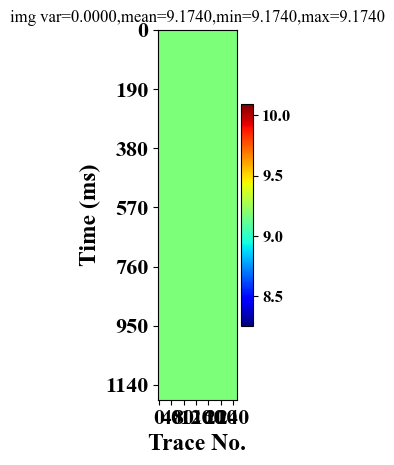

📦 从缓存加载: a835c850c5da1add98168178e87f4d3c
📦 从缓存加载: 85553c17029f0e784cec8bf202b311a8
S_obs.max() 42588.32
S_obs.min() -41888.43
save folder: /home/shendi_gjh_cj/codes/3D_project/logs/E11-4
vmin=-0.446260005235672
vmax=1.0


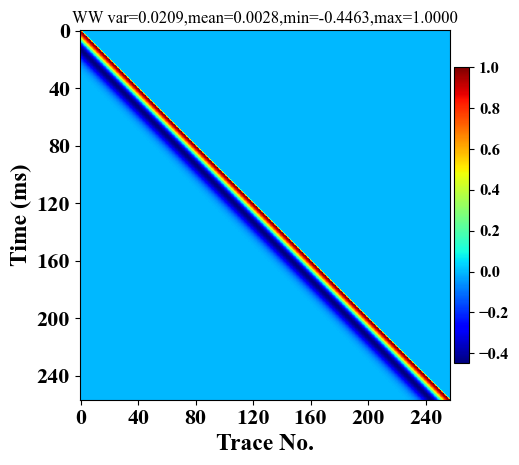

/home/shendi_gjh_cj/anaconda3/envs/ldm/lib/python3.8/site-packages/pylops/utils/signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(


vmin=-0.446260005235672
vmax=1.0


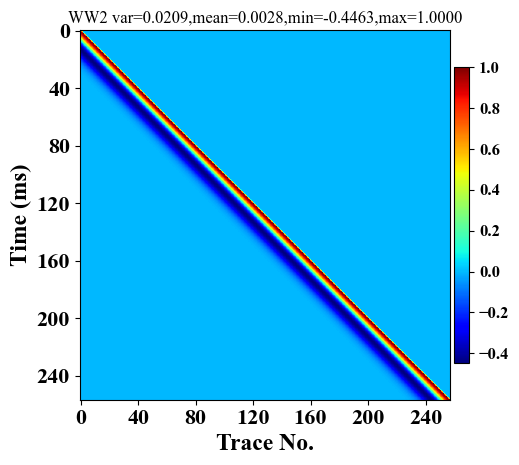

(601, 1189, 251)
vmin=-0.446260005235672
vmax=1.0


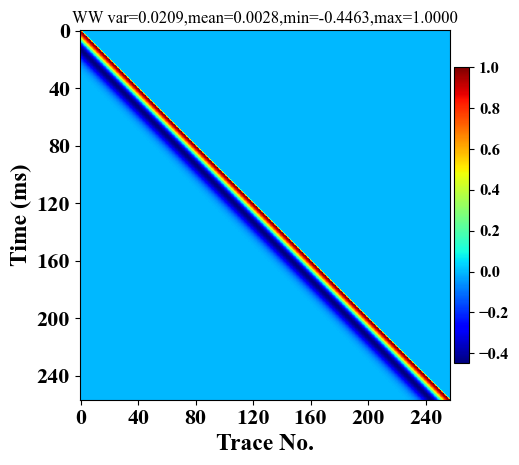

1.0


ic| WW.min(): -0.44626
ic| WW.max(): 1.0


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (257,257)->(257,newaxis,257) (601,601)->(601,601) 

In [ ]:
"""
地震阻抗反演数据处理模块
支持数据加载、预处理、缓存机制和训练数据构建
"""

import os
import pickle
import pdb
import hashlib
import numpy as np
import torch
from torch.utils import data
from scipy.signal import filtfilt
from scipy import signal
from obspy.io.segy.segy import _read_segy
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('deep_learning_impedance_inversion_chl')
from cpp_to_py import generate_well_mask as generate_well_mask2
from cpp_to_py import get_wellline_and_mask as get_wellline_and_mask2
from utils import image2cols
from Model.joint_well import add_labels
import data_tools as tools
import pdb
from icecream import ic

class SeismicDataProcessor:
    """
    地震数据处理类
    支持数据加载、预处理、缓存和训练数据构建
    """

    def __init__(self, cache_dir='cache', device=None,type='train',train_batch_size=60,train_patch_size=120,
    N_WELL_PROFILES=60,test_axis=0):
        """
        初始化数据处理器

        Args:
            train_batch_size: 训练批量大小
            train_patch_size: 训练patch大小
            N_WELL_PROFILES :生成的连井剖面个数,再根据patch_size切分
            cache_dir: 缓存目录
            device: 设备类型 ('auto', 'cpu', 'cuda')
        """
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
        self.test_axis=test_axis

        if device is not None:
            self.set_device(device)
        

        if type == 'train':
            self.config = {
                'BATCH_SIZE': train_batch_size,
                'PATCH_SIZE': train_patch_size,
                'N_WELL_PROFILES': N_WELL_PROFILES
            }


        # 数据缓存
        self._data_cache = {}
        self._normalization_params = {}

        print(f"🚀 数据处理器初始化完成:")
        print(f"   - 设备: {self.device}")
        print(f"   - 缓存目录: {cache_dir}")
        print(f"   - 配置: {self.config}")
    def get_device(self):
        ##如果存在self.device，则返回self.device，否则提示要set_device
        if hasattr(self, 'device'):
            return self.device
        else:
            raise ValueError("请先设置设备 self.set_device()")

    def set_device(self,device):
        self.device = torch.device(device)
        if self.device.type == 'cuda':
            self.dtype = torch.cuda.FloatTensor
        else:
            self.dtype = torch.FloatTensor

    def _get_cache_key(self, data_type, **kwargs):
        """生成缓存键"""
        key_parts = [data_type]
        for k, v in sorted(kwargs.items()):
            key_parts.append(f"{k}_{v}")
        key_str = "_".join(key_parts)
        return hashlib.md5(key_str.encode()).hexdigest()

    def _load_from_cache(self, cache_key):
        """从缓存加载数据"""
        cache_file = os.path.join(self.cache_dir, f"{cache_key}.pkl")
        if os.path.exists(cache_file):
            print(f"📦 从缓存加载: {cache_key}")
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        return None

    def _save_to_cache(self, cache_key, data):
        """保存数据到缓存"""
        cache_file = os.path.join(self.cache_dir, f"{cache_key}.pkl")
        print(f"💾 保存到缓存: {cache_key}")
        with open(cache_file, 'wb') as f:
            pickle.dump(data, f)

    def load_impedance_data(self, file_path="data/yyf_smo_train_Volume_PP_IMP.sgy"):
        """
        加载阻抗数据

        Args:
            file_path: 阻抗数据文件路径

        Returns:
            impedance_model_full: 完整阻抗数据
        """
        cache_key = self._get_cache_key("impedance",
                                      full_data=True,
                                      max_slices=251)

        # 尝试从缓存加载
        cached_data = self._load_from_cache(cache_key)
        if cached_data is not None:
            return cached_data

        print(f"🔄 加载阻抗数据: {file_path}")
        ##如果找不到file_path，就加绝对路径前缀
        if not os.path.exists(file_path):
            file_path = os.path.join("/home/shendi_gjh_cj/codes/3D_project", file_path)
        segy = _read_segy(file_path)
        impedance_model_full = []

        for i in range(0, len(segy.traces)):
            impedance_model_full.append(segy.traces[i].data)

        impedance_model_full = np.array(impedance_model_full).reshape(
            251, len(impedance_model_full)//251, 601
        ).transpose(2, 1, 0)

        # impedance_model_full=np.clip(impedance_model_full,6000,15000)
        pdb.set_trace()

        # 根据设备配置调整数据大小
        impedance_model_full = impedance_model_full
        # pdb.set_trace()

        impedance_model_full = np.log(impedance_model_full)

        # 保存到缓存
        self._save_to_cache(cache_key, impedance_model_full)

        print(f"✅ 阻抗数据加载完成: {impedance_model_full.shape}")
        return impedance_model_full

    def generate_low_frequency_background(self, impedance_model_full):
        """
        从完整阻抗数据生成低频背景

        Args:
            impedance_model_full: 完整阻抗数据

        Returns:
            Z_back: 低频背景阻抗
        """
        cache_key = self._get_cache_key("low_freq_background",
                                      shape=impedance_model_full.shape)

        # 尝试从缓存加载
        cached_data = self._load_from_cache(cache_key)
        if cached_data is not None:
            return cached_data

        print("🌊 生成低频背景阻抗...")
        Z_back = []

        for i in range(impedance_model_full.shape[2]):
            B, A = signal.butter(2, 0.012, 'low')  # 截止频率约12Hz
            m_loww = signal.filtfilt(B, A, impedance_model_full[..., i].T).T
            nsmooth = 3
            m_low = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m_loww)  # 时间方向平滑
            nsmooth = 3
            m_low = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m_low.T).T  # 空间方向平滑
            Z_back.append(m_low[..., None])

        Z_back = np.concatenate(Z_back, axis=2)

        # 保存到缓存
        self._save_to_cache(cache_key, Z_back)

        print(f"✅ 低频背景阻抗生成完成: {Z_back.shape}")
        return Z_back

    def load_seismic_data(self, file_path="data/PSTM_resample1_lf_extension2.sgy"):
        """
        加载地震观测数据

        Args:
            file_path: 地震数据文件路径

        Returns:
            S_obs: 观测地震数据
        """
        cache_key = self._get_cache_key("seismic",
                                      full_data=True,
                                      max_slices=251)

        # 尝试从缓存加载
        cached_data = self._load_from_cache(cache_key)
        if cached_data is not None:
            return cached_data

        print(f"🌊 加载地震观测数据: {file_path}")
        if not os.path.exists(file_path):
            file_path = os.path.join("/home/shendi_gjh_cj/codes/3D_project", file_path)
        segy_seismic = _read_segy(file_path)
        S_obs = []

        for i in range(0, len(segy_seismic.traces)):
            S_obs.append(segy_seismic.traces[i].data)

        S_obs = np.array(S_obs).reshape(251, len(S_obs)//251, 601).transpose(2, 1, 0)

        # 根据设备配置调整数据大小
        S_obs = S_obs

        # 保存到缓存
        self._save_to_cache(cache_key, S_obs)

        print(f"✅ 地震观测数据加载完成: {S_obs.shape}")
        return S_obs

    def generate_well_mask(self, shape_3d):
        """
        生成井位掩码

        Args:
            shape_3d: 3D数据形状

        Returns:
            well_pos: 井位坐标
            M_well_mask: 井位掩码
            M_well_mask_dict: 井位掩码字典
        """
        cache_key = self._get_cache_key("well_mask",
                                      shape=shape_3d[1:3],
                                      full_data=True)

        # 尝试从缓存加载
        cached_data = self._load_from_cache(cache_key)
        if cached_data is not None:
            return cached_data

        print("🎯 生成井位掩码...")

        # 网格参数
        nx, ny = shape_3d[1:3]
        basex = 450
        basey = 212

        # 定义井位
        pos = [[594,295], [572,692], [591,996], [532,1053],
               [603,1212], [561,842], [504,846], [499,597]]
        well_pos = [[y-basey, x-basex] for [x, y] in pos]

        # 生成井位掩码
        grid_shape = shape_3d[1:3]
        M_well_mask_dict = generate_well_mask2(well_pos, grid_shape, well_range=15, sigma=5)

        # 转换为2D数组格式
        M_well_mask = np.zeros(grid_shape)
        for (line, cmp), weight in M_well_mask_dict.items():
            M_well_mask[line, cmp] = weight

        result = (well_pos, M_well_mask, M_well_mask_dict)

        # 保存到缓存
        self._save_to_cache(cache_key, result)

        print(f"✅ 井位掩码生成完成:")
        print(f"   - 井位数量: {len(well_pos)}")
        print(f"   - 掩码形状: {M_well_mask.shape}")

        return result

    def build_training_profiles(self,well_pos, M_well_mask_dict):
        """
        构建训练剖面数据

        Args:
            Z_back: 低频背景阻抗
            impedance_model_full: 完整阻抗数据
            S_obs: 观测地震数据
            well_pos: 井位坐标
            M_well_mask_dict: 井位掩码字典

        Returns:
            training_data: 训练数据字典
        """
        cache_key = self._get_cache_key("training_profiles",
                                      n_profiles=self.config['N_WELL_PROFILES'],
                                      patch_size=self.config['PATCH_SIZE'])

        # 尝试从缓存加载
        cached_data = self._load_from_cache(cache_key)
        if cached_data is not None:
            return cached_data


        print("📦 构建训练剖面数据...")

        # 1. 加载3D阻抗数据 601*1189*251
        impedance_model_full = self.load_impedance_data()           
        # 2. 生成3D低频背景 601*1189*251
        Z_back = self.generate_low_frequency_background(impedance_model_full)   
        # 3. 加载3D地震数据 601*1189*251
        S_obs = self.load_seismic_data()

        # 训练井位
        train_well = add_labels(well_pos)
        grid_shape = S_obs.shape[1:3]

        # 存储各类剖面数据
        Z_back_profiles = []
        Z_full_profiles = []
        S_obs_profiles = []
        M_mask_profiles = []
        path_coords = []

        print("   正在生成连井剖面...")
        for i in tqdm(range(self.config['N_WELL_PROFILES']), desc="生成剖面"):
            # 生成随机连井剖面
            interpolated_points, vMask = get_wellline_and_mask2(
                well_pos, grid_shape, M_well_mask_dict
            )

            path_coords.append(interpolated_points)

            # 扩展掩码到时间维度
            vMask_time_extended = np.tile(vMask, (601, 1))
            M_mask_profiles.append(vMask_time_extended)

            # 提取沿剖面的数据
            Z_back_profiles.append(Z_back[:, interpolated_points[:, 0], interpolated_points[:, 1]])
            Z_full_profiles.append(impedance_model_full[:, interpolated_points[:, 0], interpolated_points[:, 1]])
            S_obs_profiles.append(S_obs[:, interpolated_points[:, 0], interpolated_points[:, 1]])

        # 滑窗切分统一尺寸
        patchsize = self.config['PATCH_SIZE']
        oversize = patchsize-10

        Z_back_patches = []
        Z_full_patches = []
        S_obs_patches = []
        M_mask_patches = []

        print("   正在切分训练块...")
        for i in tqdm(range(self.config['N_WELL_PROFILES']), desc="切分数据"):
            Z_back_patches.append(torch.tensor(image2cols(
                Z_back_profiles[i], (S_obs.shape[0], patchsize), (1, oversize)
            )))
            Z_full_patches.append(torch.tensor(image2cols(
                Z_full_profiles[i], (S_obs.shape[0], patchsize), (1, oversize)
            )))
            S_obs_patches.append(torch.tensor(image2cols(
                S_obs_profiles[i], (S_obs.shape[0], patchsize), (1, oversize)
            )))
            M_mask_patches.append(torch.tensor(image2cols(
                M_mask_profiles[i], (S_obs.shape[0], patchsize), (1, oversize)
            )))

        # 把列表内容拼接成numpy，列表中的内容是163*601*120*120，拼接后是5553*1*601*120
        Z_back_patches_np = np.concatenate(Z_back_patches, axis=0)[..., None].transpose(0, 3, 1, 2)
        Z_full_patches_np = np.concatenate(Z_full_patches, axis=0)[..., None].transpose(0, 3, 1, 2)
        S_obs_patches_np = np.concatenate(S_obs_patches, axis=0)[..., None].transpose(0, 3, 1, 2)
        M_mask_patches_np = np.concatenate(M_mask_patches, axis=0)[..., None].transpose(0, 3, 1, 2)


        training_data = {
            'Z_back_train_set': Z_back_patches_np,
            'Z_full_train_set': Z_full_patches_np,
            'S_obs_train_set': S_obs_patches_np,
            'M_mask_train_set': M_mask_patches_np,
            '3D_shape':impedance_model_full.shape
        }

        # 保存到缓存
        self._save_to_cache(cache_key, training_data)

        print(f"✅ 训练剖面数据构建完成:")
        print(f"   - 3D阻抗数据形状: {training_data['3D_shape']}")
        print(f"构建{len(Z_back_profiles)}个剖面，每个剖面形状为{Z_back_profiles[0].shape}")
        print(f"构建后的全部patch,整体形状为{Z_back_patches_np.shape}")

        return training_data



    def process_train_data(self):
        """
        只处理训练数据
        Returns:
            train_loader: 训练数据加载器
            normalization_params: 归一化参数
            data_info: 数据信息字典
        """
        print("\n" + "="*80)
        print("🚀 开始训练数据处理流程")
        print("="*80)

        # 1. 加载3D地震数据 601*1189*251
        S_obs = self.load_seismic_data()      ##其实这里加载只是为了获取大小信息
        shape_3d=S_obs.shape

        # 4. 生成井位掩码
        well_pos, M_well_mask, M_well_mask_dict = self.generate_well_mask(shape_3d)
        # 5. 构建训练剖面数据
        training_data = self.build_training_profiles(
         well_pos, M_well_mask_dict
        )

        # 6. 数据归一化（直接写在此处）
        logimpmax = training_data['Z_full_train_set'].max()
        logimpmin = training_data['Z_full_train_set'].min()
        S_obs_min = training_data['S_obs_train_set'].min()
        S_obs_max = training_data['S_obs_train_set'].max()
        pdb.set_trace()
        # Z_full_norm=training_data['Z_full_train_set']
        Z_full_norm = (training_data['Z_full_train_set'] - logimpmin) / (logimpmax - logimpmin)

        S_obs_norm=training_data['S_obs_train_set']/1000
        # S_obs_norm = 2 * (training_data['S_obs_train_set'] - S_obs_min) / (S_obs_max - S_obs_min) - 1
        Z_back_norm = (training_data['Z_back_train_set'] - logimpmin) / (logimpmax - logimpmin)

        # def DIFFZ(z):
        #     DZ=np.zeros([z.shape[0], z.shape[1], z.shape[2], z.shape[3]], dtype=np.float32)
        #     DZ[...,:-1,:] = 0.5*(z[...,1:, :] - z[..., :-1, :])
        #     return DZ
        # from codes.wi_inv_socket import custom_convmtx
        # from utils import wavelet_init
        # pdb.set_trace()
        # print(Z_full_norm.shape)
        # wav = wavelet_init(257).squeeze().numpy()
        # WW = custom_convmtx(wav, 601, 300)
        # WW = WW.astype(np.float32)
        # re_sesimic=WW@DIFFZ(Z_full_norm)
        # plt.plot(re_sesimic[0,0,:,141],label="re_sesimic")
        # plt.plot(S_obs_norm[0,0,:,10],label="S_obs_norm")
        # plt.legend()
        # plt.show()


        # 7. 创建训练数据加载器
        # 将数据移动到指定设备
        train_loader = data.DataLoader(
            data.TensorDataset(
                torch.tensor(S_obs_norm, dtype=torch.float32, device=self.device),
                torch.tensor(Z_full_norm, dtype=torch.float32, device=self.device),
                torch.tensor(Z_back_norm, dtype=torch.float32, device=self.device),
                torch.tensor(training_data['M_mask_train_set'], dtype=torch.float32, device=self.device)
            ),
            batch_size=self.config['BATCH_SIZE'],
            shuffle=True
        )
        # 数据信息
        data_info = {
            '3D_shape': shape_3d,
            'well_positions': well_pos,
            'config': self.config,
            'batch_shape':S_obs_norm.shape
        }
        normalization_params = {
            'logimpmax': logimpmax,
            'logimpmin': logimpmin,
            'S_obs_min': S_obs_min,
            'S_obs_max': S_obs_max
        }
        print("\n" + "="*80)
        print("✅ 训练数据处理流程完成")
        print(f"数据集大小为{S_obs_norm.shape}")
        print("="*80)
        return train_loader, normalization_params, data_info



    def build_test_patches_regular(self, S_obs, Z_back, impedance_model_full, patch_size, oversize=70, axis=0):
        """
        沿axis方向滑窗切patch，生成2D剖面与训练数据维度一致。
        axis=0: x方向滑窗（inline），axis=1: y方向滑窗（xline）
        返回: patches, zback_patches, imp_patches, indices, shape3d
        """
        n_time, n_x, n_y = S_obs.shape
        spatial_shape = [n_x, n_y]
        patches, zback_patches, imp_patches, indices = [], [], [], []
        slide_len = spatial_shape[axis]
        keep_len = spatial_shape[1-axis]

        patch_size = min(patch_size, slide_len)
        # 生成滑窗位置
        start_begin = list(range(0, slide_len - patch_size + 1, oversize))
        start_begin += [slide_len - patch_size]
        
        for start in start_begin:
            # 沿另一个方向生成多个2D剖面
            for j in range(keep_len):
                if axis == 0:
                    # x方向滑窗，y=j，生成2D剖面 [601, patch_size]
                    patch = S_obs[:, start:start+patch_size, j]
                    zback_patch = Z_back[:, start:start+patch_size, j]
                    imp_patch = impedance_model_full[:, start:start+patch_size, j]
                    indices.append((start, j))
                else:
                    # y方向滑窗，x=j，生成2D剖面 [601, patch_size]
                    patch = S_obs[:, j, start:start+patch_size]
                    zback_patch = Z_back[:, j, start:start+patch_size]
                    imp_patch = impedance_model_full[:, j, start:start+patch_size]
                    indices.append((j, start))
                
                patches.append(torch.tensor(patch, dtype=torch.float32))
                zback_patches.append(torch.tensor(zback_patch, dtype=torch.float32))
                imp_patches.append(torch.tensor(imp_patch, dtype=torch.float32))
        
        # 将patch列表堆叠成张量，与训练数据维度一致 [num_patches, 1, time, patch_size]
        patches = torch.stack(patches).unsqueeze(1)
        zback_patches = torch.stack(zback_patches).unsqueeze(1)
        imp_patches = torch.stack(imp_patches).unsqueeze(1)
        
        shape3d = (n_time, n_x, n_y)
        return patches, zback_patches, imp_patches, indices, shape3d

    def process_test_data(self, batch_size=500, patch_size=70, test_number=None):
        """
        返回测试patch loader、patch索引、shape3d、归一化参数，支持方向选择
        axis: 0(x方向滑窗/inline) 或 1(y方向滑窗/xline)
        """
        self.test_number = test_number
        impedance_model_full = self.load_impedance_data()
        tools.single_imshow(impedance_model_full[0])
        Z_back = self.generate_low_frequency_background(impedance_model_full)
        S_obs = self.load_seismic_data()
        logimpmax = impedance_model_full.max()
        logimpmin = impedance_model_full.min()
        
        print("S_obs.max()",S_obs.max())
        print("S_obs.min()",S_obs.min())
        S_obs_norm=S_obs/12000
        # S_obs_norm = 2 * (S_obs - S_obs.min()) / (S_obs.max() - S_obs.min()) - 1
        Z_back_norm = (Z_back - logimpmin) / (logimpmax - logimpmin)
        # Z_back_norm=Z_back

        Z_full_norm = (impedance_model_full - logimpmin) / (logimpmax - logimpmin)
        # Z_full_norm=impedance_model_full
        # pdb.set_trace()
        def DIFFZ(z):
            DZ=np.zeros(z.shape, dtype=np.float32)
            DZ[:-1,:,:] = 0.5*(z[1:,:,:] - z[:-1,:,:])
            return DZ
        from codes.wi_inv_socket import custom_convmtx
        from utils import wavelet_init
        # pdb.set_trace()
        print(Z_full_norm.shape)
        # tools.single_imshow(Z_full_norm[:,:,144])
        
        # wav = wavelet_init(601).squeeze().numpy()
        # WW = custom_convmtx(wav, 300, 150)
        # WW = WW.astype(np.float32)
        # tools.single_imshow(WW[:,:],title="WW")

        # from utils import wavelet_init
        wav = wavelet_init(257).squeeze().numpy()
        WW = custom_convmtx(wav, 257, 0)
        WW = WW.astype(np.float32)
        tools.single_imshow(WW[:,:],title="WW")
        

        print(abs(WW).max())
        # pdb.set_trace()
        ic(WW.min())
        ic(WW.max())

        S= np.diag(0.5 * np.ones(601-1, dtype='float32'), k=1) - np.diag(
                0.5 * np.ones(601-1, dtype='float32'), -1)
        S[0] = S[-1] = 0
        WS=np.einsum('ij,jk->ik', WW, S)    ##601*601
        re_sesimic=WS@Z_full_norm[:,:,82]  ##601*1189


        # inline=480
        # xline=122
        inline,xline=480,122
        # inline,xline=83,144
        # inline,xline=784,141


        # re_sesimic=np.einsum('ij,jk->ik', WW, Z_full_norm[:,:,xline])  ##601*601 601*1189 
        pdb.set_trace()
        # tools.single_imshow(re_sesimic)
        # tools.single_imshow(Z_full_norm[:,:,xline])
        # plt.show()
        # print(Z_full_norm[:,inline,xline])
        # print()

        plt.plot(wav,label="wav")
        plt.plot(Z_full_norm[:,inline,xline],label="Z_full_norm")
        plt.title("well: inline="+str(inline)+",xline="+str(xline))
        plt.show()


        pdb.set_trace()
        tem=(S@Z_full_norm[:,:,xline])[:,inline]
        plt.plot(tem,label="S*Z_full_norm")
        plt.title("inline="+str(inline)+",xline="+str(xline))
        # pdb.set_trace()
        plt.legend()
        plt.show()
        plt.legend()
        plt.plot(re_sesimic[:,xline],label="re_sesimic")
        plt.plot(S_obs_norm[:,inline,xline],label="S_obs_norm")
        plt.legend()
        plt.title("inline="+str(inline)+",xline="+str(xline))
        plt.show()

        # print("S_obs.min()",S_obs.min())
        # print("S_obs.max()",S_obs.max())
        # print("re_sesimic.min()",re_sesimic.min())
        # print("re_sesimic.max()",re_sesimic.max())
        
        # 使用传入的axis参数
        patches, zback_patches, imp_patches, indices, shape3d = self.build_test_patches_regular(
            S_obs_norm, Z_back_norm, Z_full_norm, patch_size, patch_size-10, axis=self.test_axis
        )
        
        if test_number is None:
            test_number = len(patches)

        indices_tensor = torch.tensor(indices[:test_number], dtype=torch.int)
        test_loader = data.DataLoader(
            data.TensorDataset(patches[:test_number], imp_patches[:test_number], zback_patches[:test_number], indices_tensor[:test_number]),
            batch_size=batch_size, shuffle=False
        )
        
        # 完整的归一化参数
        normalization_params = {
            'logimpmax': logimpmax, 
            'logimpmin': logimpmin,
            'S_obs_min': S_obs.min(),
            'S_obs_max': S_obs.max()
        }

        return test_loader, indices, shape3d, normalization_params

    def reconstruct_3d_from_patches(self, pred_patches, indices):
        """
        从2D剖面重建3D数据
        pred_patches: patch列表，每个patch形状为 [time, patch_size]
        indices: [(i, j)] 位置索引
        """
        
        assert len(pred_patches) == len(indices), "pred_patches 和 indices 长度不匹配"
        assert len(pred_patches[0].shape) == 2, "pred_patches 形状不正确"
        
        # 获取patch尺寸
        # print("pred_patches[0].shape", pred_patches[0].shape)
        n_time = pred_patches[0].shape[0]  # 时间维度
        patch_size = pred_patches[0].shape[1]  # 空间维度
        
        # print(f"🔍 重建信息:")
        # print(f"   - pred_patches 数量: {len(pred_patches)}")
        # print(f"   - indices 数量: {len(indices)}")
        # print(f"   - patch 形状: {pred_patches[0].shape}")
        # print(f"   - test_axis: {self.test_axis}")
        
        # 根据indices推断空间尺寸
        if self.test_axis == 0:
            max_i = max(idx[0] for idx in indices) + patch_size
            max_j = max(idx[1] for idx in indices) + 1
        else:
            max_i = max(idx[0] for idx in indices) + 1
            max_j = max(idx[1] for idx in indices) + patch_size
        n_x, n_y = max_i, max_j

        volume = np.zeros((n_time, n_x, n_y))
        count = np.zeros((n_time, n_x, n_y))

        for idx, (i, j) in enumerate(indices):
            patch = pred_patches[idx]  # [time, patch_size]
            
            if self.test_axis == 0:
                # x方向滑窗，y=j
                volume[:, i:i+patch_size, j] += patch
                count[:, i:i+patch_size, j] += 1
            else:
                # y方向滑窗，x=j
                volume[:, i, j:j+patch_size] += patch
                count[:, i, j:j+patch_size] += 1
                
        volume /= np.maximum(count, 1)
        return volume

if __name__ == "__main__":
    """测试数据处理模块"""
    # 创建数据处理器
    processor = SeismicDataProcessor(cache_dir='cache',device='cpu',train_batch_size=60,train_patch_size=120)
    # train_loader, normalization_params, data_info = processor.process_train_data()
    test_loader, indices, shape3d, norm_params = processor.process_test_data()
    # S_obs = processor.load_seismic_data()      ##其实这里加载只是为了获取大小信息
    # shape_3d=S_obs.shape
    # print(shape_3d)
    
    # # 4. 生成井位掩码
    # well_pos, M_well_mask, M_well_mask_dict = processor.generate_well_mask(shape_3d)
    # # 5. 构建训练剖面数据
    # training_data = processor.build_training_profiles(
    #     well_pos, M_well_mask_dict
    # )
    # pdb.set_trace()
    ##读取train_loader的第1个数据
    
    # for idx, batch in enumerate(train_loader):
    #     print(idx)
    #     if idx ==3:
    #         S_obs_batch, Z_full_batch, Z_back_batch, M_mask_batch=batch
    #         break


    # for S_obs_batch, Z_full_batch, Z_back_batch, M_mask_batch in train_loader:
    #     print(S_obs_batch.shape)
    #     print(Z_full_batch.shape)
    #     print(Z_back_batch.shape)
    #     print(M_mask_batch.shape)
    #     break


    # # 假设原始 3D 数据
    # S_obs = np.random.rand(601, 1189, 251).astype(np.float32)
    # Z_back = np.random.rand(601, 1189, 251).astype(np.float32)
    # impedance_model_full = np.random.rand(601, 1189, 251).astype(np.float32)

    # # 切分
    # patches, zback_patches, imp_patches, indices, shape3d = processor.build_test_patches_regular(
    #     S_obs, Z_back, impedance_model_full, patch_size=500, oversize=70, axis=0
    # )
    # # 拼接
    # reconstructed = processor.reconstruct_3d_from_patches(patches)

    # # 验证
    # assert reconstructed.shape == S_obs.shape, f"拼接后的形状 {reconstructed.shape} 与原始形状 {S_obs.shape} 不一致"
    # print("切分和拼接逻辑匹配，数据一致！")

    # impedance_model_full = processor.load_impedance_data()
    # Z_back = processor.generate_low_frequency_background(impedance_model_full)
    # S_obs = processor.load_seismic_data()
    # logimpmax = impedance_model_full.max()
    # logimpmin = impedance_model_full.min()
    # S_obs_norm = 2 * (S_obs - S_obs.min()) / (S_obs.max() - S_obs.min()) - 1
    # Z_back_norm = (Z_back - logimpmin) / (logimpmax - logimpmin)
    # Z_full_norm = (impedance_model_full - logimpmin) / (logimpmax - logimpmin)
    # patch_size = processor.config['PATCH_SIZE']
    # processor.test_axis=0
    # patches, zback_patches, imp_patches, indices, shape3d = processor.build_test_patches_regular(
    #     S_obs_norm, Z_back_norm, Z_full_norm, patch_size=70, axis=0
    # )
    # %%
    # tools.single_imshow(impedance_model_full[:,:,0])
    # tools.single_imshow(Z_back[:,:,0])
    # tools.single_imshow(S_obs[:,:,0])

In [ ]:
    ##打印数据信息
    # print(f"\n📊 数据处理结果:")
    # print(f"   - 阻抗数据形状: {data_info['impedance_shape']}")
    # print(f"   - 地震数据形状: {data_info['seismic_shape']}")
    # print(f"   - 井位数量: {len(data_info['well_positions'])}")
    # print(f"   - 训练批数: {len(train_loader)}")
    # print(f"   - 测试批数: {len(test_loader)}")
    # print(f"   - 归一化参数: {norm_params}")

: 